# ARIMAX

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Modelo

In [4]:
from itertools import product

def fit_best_sarimax(df_daily, df_weekly, contaminante, y_transform=None, inverse_transform=None):
   
    def fit_model(df, freq_label):
        """Ajusta SARIMAX para un dataframe (diario o semanal), buscando mejores hyperparametros."""

        Y_orig = df[contaminante]
        X = df[['TOUT','RH','SR','PRS','WSR','WDR']]

        # Aplicar transformación a la variable contaminante si se especifica
        if y_transform is not None:
            Y = y_transform(Y_orig)
        else:
            Y = Y_orig

        # split
        split = int(len(df)*0.8)
        Y_train, Y_test = Y.iloc[:split], Y.iloc[split:]
        Y_train_orig, Y_test_orig = Y_orig.iloc[:split], Y_orig.iloc[split:]
        X_train, X_test = X.iloc[:split], X.iloc[split:]

        # scaler sin leakage
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # buscar mejores hiperparámetros (order)
        best_aic = np.inf
        best_result = None
        best_order = None

        # rangos - p = [1,2,3], d = [0,1], q = [1,2,3]
        for order in product([1,2,3,4,5], [0,1], [1,2,3,4,5]):
            try:
                model = SARIMAX(
                    Y_train,
                    exog=X_train_scaled,
                    order=order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_result = results
                    best_order = order
            except Exception as e:
                continue  # ignora combinaciones que no convergen, etc.

        # predicciones con mejores parámetros (en espacio transformado)
        pred_trans = best_result.predict(start=len(Y_train), end=len(Y)-1, exog=X_test_scaled)
        # Invertir la transformación si corresponde, para comparar en escala original
        if inverse_transform is not None and y_transform is not None:
            pred = inverse_transform(pred_trans)
        else:
            pred = pred_trans

        # En todos los casos las métricas se calculan en escala original
        mae  = mean_absolute_error(Y_test_orig, pred)
        rmse = np.sqrt(mean_squared_error(Y_test_orig, pred))
        r2   = r2_score(Y_test_orig, pred)
        # Nueva métrica: MAPE
        mape = np.mean(np.abs((Y_test_orig - pred) / Y_test_orig)) * 100

        # residual diagnostics (trabajo en espacio transformado)
        resid = best_result.resid
        lb_p = sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
        jb_p = sm.stats.jarque_bera(resid)[1]

        # ranking importancia
        coefs = best_result.params.filter(regex='^x')
        coef_table = pd.DataFrame({
            'Variable': X.columns,
            'Coef': coefs.values,
            'AbsImpact': np.abs(coefs.values),
            'Pvalue': best_result.pvalues.filter(regex='^x').values
        }).sort_values('AbsImpact', ascending=False)

        summary = {
            "freq": freq_label,
            "AIC": best_aic,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape,
            "R2": r2,
            "LjungBox_p": lb_p,
            "JarqueBera_p": jb_p,
            "coef_table": coef_table,
            "results": best_result,
            "scaler": scaler,
            "Y_test": Y_test_orig,
            "pred": pred,
            "best_order": best_order,
            "y_transform": y_transform,
            "inverse_transform": inverse_transform,
        }

        return summary
    
    # --- Ajustar ambos modelos ---
    daily_model  = fit_model(df_daily,  "Diario")
    weekly_model = fit_model(df_weekly, "Semanal")

    # --- Selección automática ---
    #best = daily_model if daily_model["R2"] > weekly_model["R2"] else weekly_model
    best_daily = daily_model
    best_weekly = weekly_model

    return {
        "best_daily": best_daily,
        "best_weekly": best_weekly,
        "daily": daily_model,
        "weekly": weekly_model
    }
    
def plot_diagnostics(result_dict):
    results = result_dict["results"]
    resid = results.resid

    # residuales
    plt.figure(figsize=(12,4))
    plt.plot(resid)
    plt.axhline(0, color="black")
    plt.title("Residuales")
    plt.show()

    # ACF / PACF
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    sm.graphics.tsa.plot_acf(resid, ax=ax[0], lags=40)
    sm.graphics.tsa.plot_pacf(resid, ax=ax[1], lags=40)
    plt.show()

    # QQ plot
    sm.qqplot(resid, line='45')
    plt.title("QQ Plot")
    plt.show()

    # Hist residual
    plt.hist(resid, bins=30, edgecolor='black')
    plt.title("Histograma de residuales")
    plt.show()


# CENTRO

## data

In [9]:
# Estandarizar columnas relevantes en 'centro'
CENTRO = pd.read_csv("df_CENTRO_22_25.csv")
CENTRO["PM10_std"] = (CENTRO["PM10"] - CENTRO["PM10"].mean()) / CENTRO["PM10"].std()
CENTRO["PM2.5_std"] = (CENTRO["PM2.5"] - CENTRO["PM2.5"].mean()) / CENTRO["PM2.5"].std()
CENTRO["NO_std"] = (CENTRO["NO"] - CENTRO["NO"].mean()) / CENTRO["NO"].std()
CENTRO["NO2_std"] = (CENTRO["NO2"] - CENTRO["NO2"].mean()) / CENTRO["NO2"].std()
CENTRO["SO2_std"] = (CENTRO["SO2"] - CENTRO["SO2"].mean()) / CENTRO["SO2"].std()
CENTRO["O3_std"] = (CENTRO["O3"] - CENTRO["O3"].mean()) / CENTRO["O3"].std()  # Agrega estandarización de O3

# Crear los grupos Y en 'centro', incluyendo la fecha de captura
CENTRO["Y_1"] = CENTRO["O3_std"]
CENTRO["PM10"] = CENTRO["PM10"]
CENTRO["PM2.5"] = CENTRO["PM2.5"]
CENTRO["Y_3"] = CENTRO[["NO_std", "NO2_std"]].mean(axis=1)
CENTRO["Y_4"] = CENTRO["SO2"] 
# Incluye la columna "date" en el DataFrame resultado
centro_Y = CENTRO[["date", "Y_1","PM10", "PM2.5", "Y_3", "Y_4","TOUT", "RH", "SR", "PRS", "WSR", "WDR"]]


# --- Diario: ozono ('Y_1') con máximo, el resto con promedio ---
df_Centro_diario = centro_Y.copy()
df_Centro_diario['date'] = pd.to_datetime(df_Centro_diario['date'])
df_Centro_diario = df_Centro_diario.set_index('date')
df_Y_diario = df_Centro_diario.resample("D").mean()

# --- Semanal: ozono ('Y_1') con máximo semanal, resto promedio ---
df_Centro_semanal = centro_Y.copy()
df_Centro_semanal['date'] = pd.to_datetime(df_Centro_semanal['date'])
df_Centro_semanal = df_Centro_semanal.set_index('date')
df_Y_semanal = df_Centro_semanal.resample("W").mean()
df_Y_semanal.describe().T


,count,mean,std,min,25%,50%,75%,max
Y_1,184.0,-0.002414,0.399573,-0.959054,-0.225114,-0.062725,0.230668,1.053054
PM10,184.0,60.887836,18.415288,18.291667,47.709821,59.157738,72.809524,131.041667
PM2.5,184.0,24.621118,8.304649,5.392917,18.427560,23.779702,30.054405,51.009524
Y_3,184.0,-0.004381,0.448880,-0.702212,-0.384817,-0.140135,0.312670,1.409012
Y_4,184.0,4.656010,1.611602,2.021429,3.212426,4.571577,5.853348,9.627976
TOUT,184.0,22.763482,5.688663,7.593929,19.045387,23.822381,27.507173,32.866250
RH,184.0,54.323019,11.543348,20.476190,47.157738,54.261905,62.933036,88.726190
SR,184.0,0.182639,0.066916,0.021726,0.128318,0.186339,0.224836,0.365238
PRS,184.0,711.361839,2.380835,706.201786,709.781994,711.289583,712.759524,717.991667
WSR,184.0,-5.051097,2.279169,-11.117024,-6.713423,-4.958571,-3.187068,0.450298


## Y_1 (Ozono)

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 211.26882123184393
MAE: 0.3269579325838216
RMSE: 0.3962866399992485
MAPE: 173.79265351477105
R2: 0.45612541421041186
LjungBox_p: 0.5633611778282951
JarqueBera_p: 6.380483565027273e-07
best_order: (4, 0, 3)
  Variable      Coef  AbsImpact        Pvalue
1       RH -0.174120   0.174120  1.652902e-37
2       SR  0.117190   0.117190  1.873844e-16
4      WSR -0.048625   0.048625  4.787353e-07
3      PRS  0.030656   0.030656  6.316831e-02
0     TOUT  0.027519   0.027519  3.542631e-01
5      WDR  0.023622   0.023622  4.167134e-03
                               SARIMAX Results                                
Dep. Variable:                    Y_1   No. Observations:                 1021
Model:               SARIMAX(4, 0, 3)   Log Likelihood                 -91.634
Date:                Fri, 05 Dec 2025   AIC                            211.269
Time:                        06:42:18   BIC                            280.213
Sample:                    01-01-2022   

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


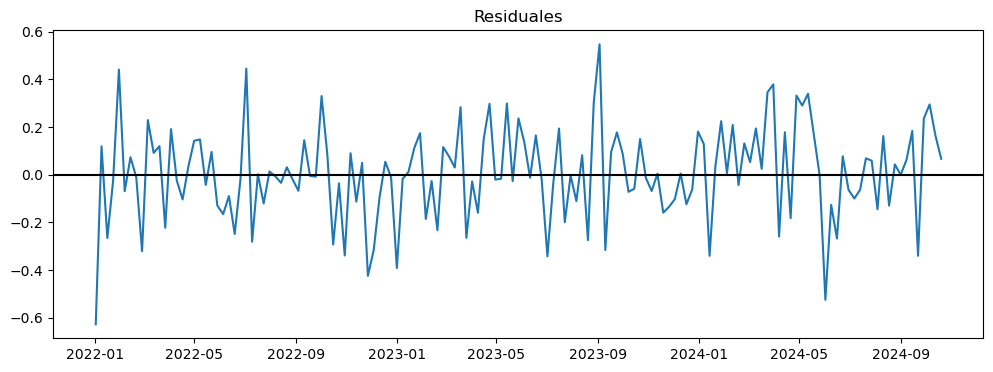

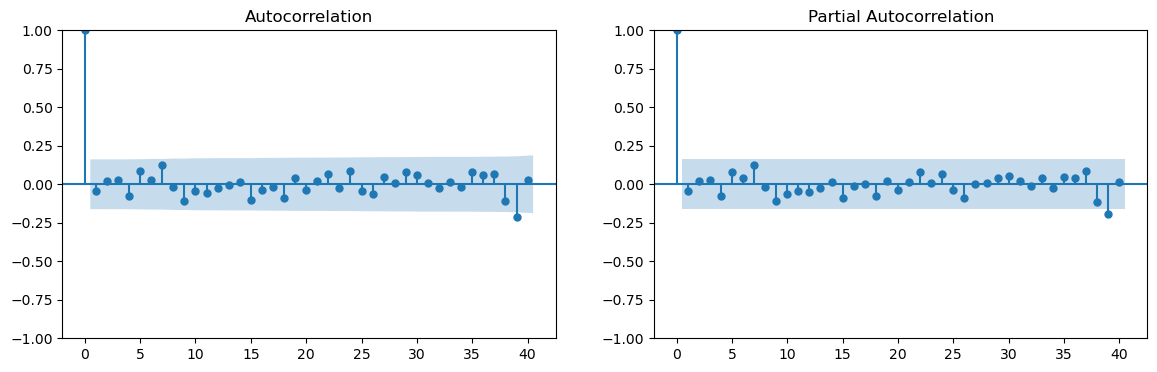

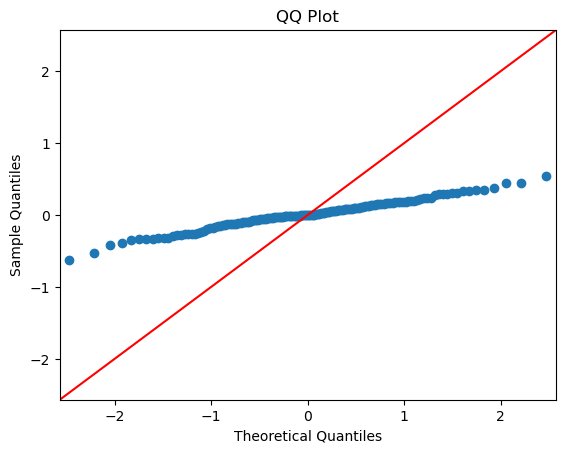

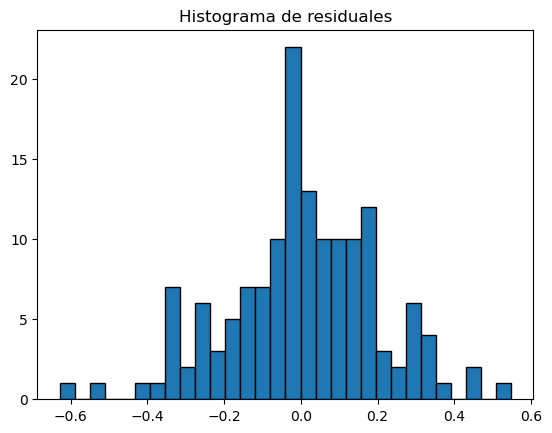

Desviación Estándar de Y_1: 0.399573182459628
Tu RMSE: 0.34844531019470876
¡El modelo FUNCIONA! Es predictivo.


In [50]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "Y_1", y_transform=None, inverse_transform=None)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

std_dev = df_Y_semanal['Y_1'].std()
print(f"Desviación Estándar de Y_1: {std_dev}")
print(f"Tu RMSE: {best['RMSE']}")

if best['RMSE'] < std_dev:
    print("¡El modelo FUNCIONA! Es predictivo.")
else:
    print("Cuidado: El modelo no es mejor que el promedio.")

## PM10

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: -142.17974419087813
MAE: 19.35202000210019
RMSE: 28.680288024868332
MAPE: 34.14869456397708
R2: -0.1480999167280459
LjungBox_p: 0.3407926270962032
JarqueBera_p: 0.0
best_order: (3, 1, 1)
  Variable      Coef  AbsImpact        Pvalue
0     TOUT  0.115631   0.115631  6.249782e-09
3      PRS -0.077850   0.077850  1.128335e-11
1       RH -0.062673   0.062673  1.121057e-08
4      WSR  0.039865   0.039865  4.082030e-07
5      WDR -0.019437   0.019437  1.893085e-03
2       SR -0.004222   0.004222  7.356647e-01
                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1021
Model:               SARIMAX(3, 1, 1)   Log Likelihood                  82.090
Date:                Fri, 05 Dec 2025   AIC                           -142.180
Time:                        08:02:33   BIC                            -88.009
Sample:                    01-01-2022   HQIC               

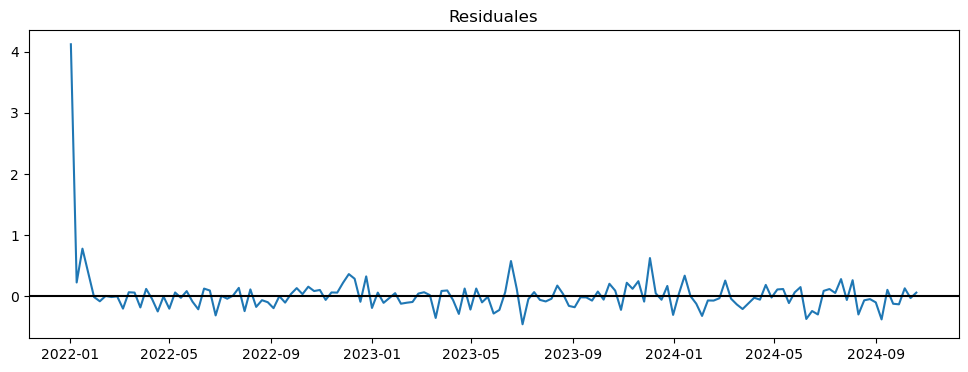

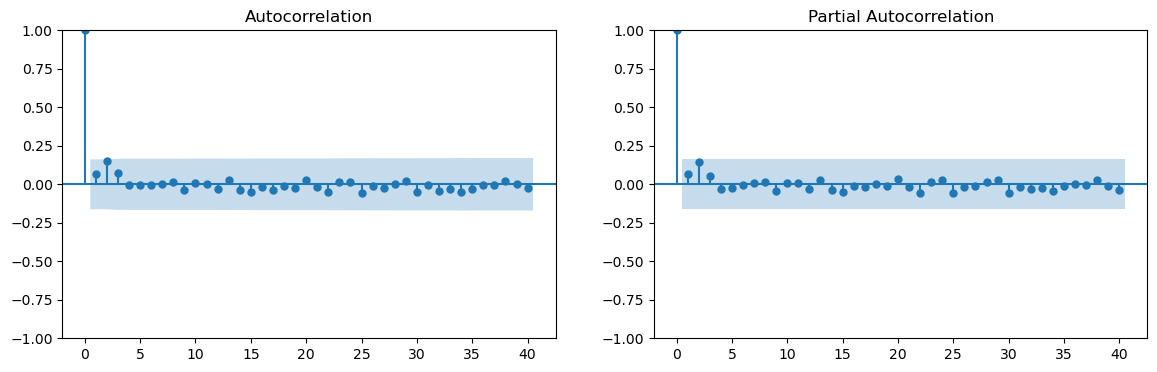

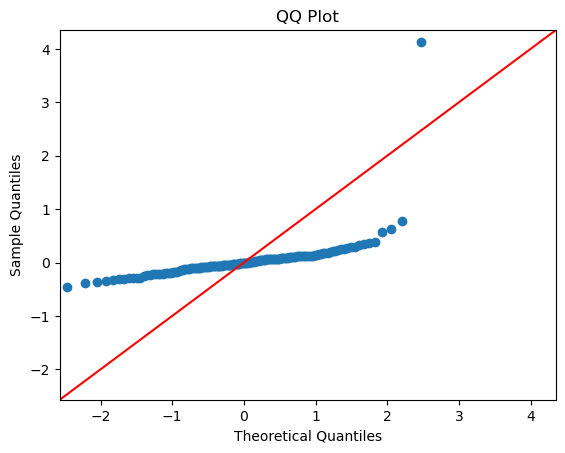

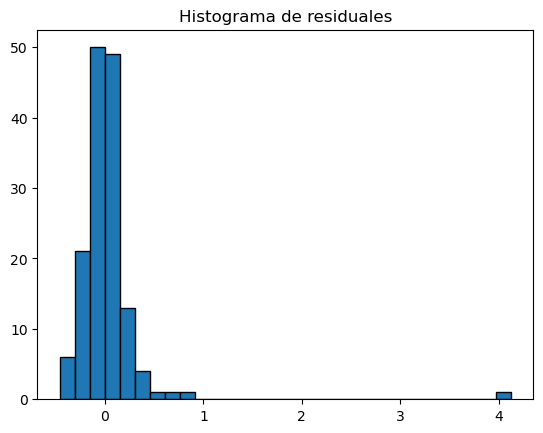

In [12]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "PM10", y_transform=np.log1p, inverse_transform=np.expm1)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

## PM 2.5

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 7085.100212496942
MAE: 12.986293299475822
RMSE: 16.388405226863135
MAPE: 51.212653492641856
R2: -1.0362101799177155
LjungBox_p: 0.6561086158966911
JarqueBera_p: 2.340977500320751e-268
best_order: (4, 1, 5)
  Variable      Coef  AbsImpact        Pvalue
1       RH  3.869684   3.869684  2.164641e-20
0     TOUT  3.390221   3.390221  8.371408e-06
3      PRS -2.487088   2.487088  3.210962e-09
2       SR  1.395479   1.395479  4.119761e-03
4      WSR  1.144455   1.144455  5.796500e-05
5      WDR  0.477638   0.477638  7.825609e-02
                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1021
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -3526.550
Date:                Fri, 05 Dec 2025   AIC                           7085.100
Time:                        08:08:52   BIC                           7163.847
Sample:                    01-01-2022   

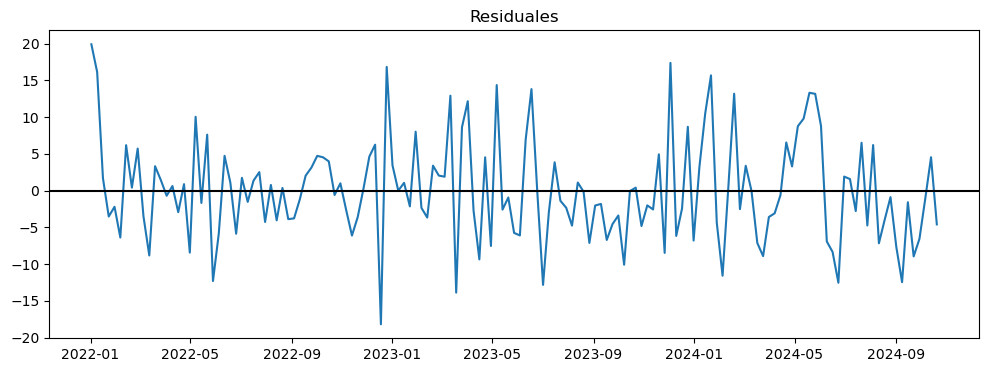

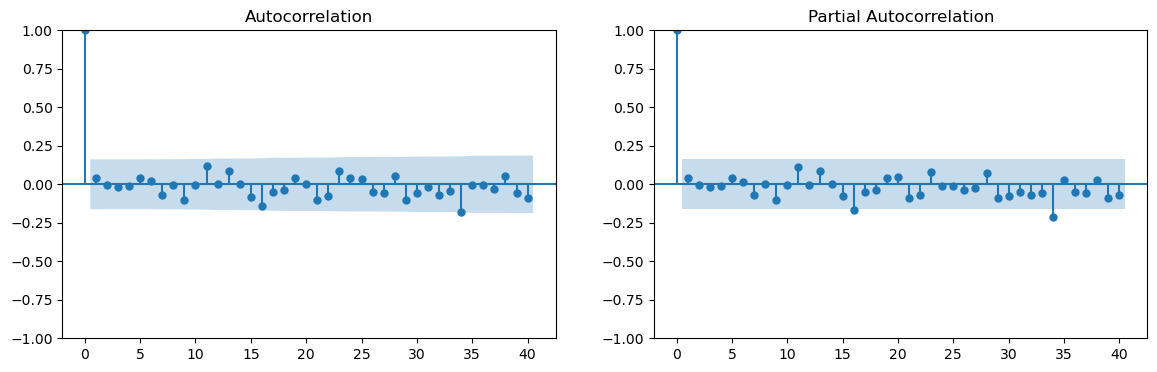

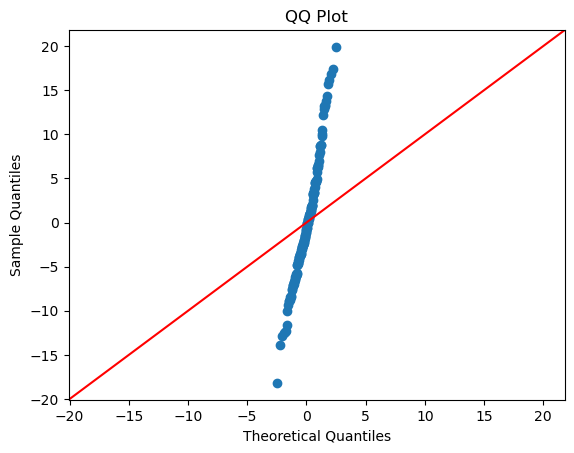

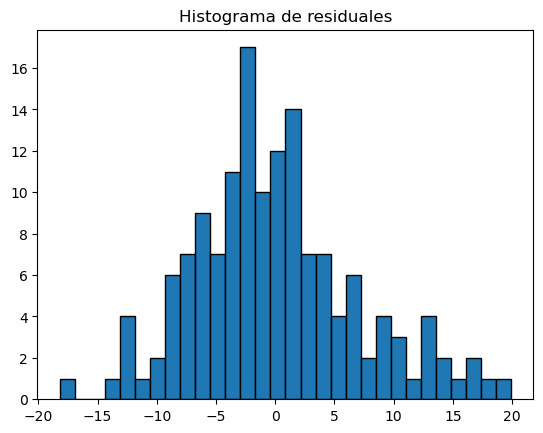

In [15]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "PM2.5", y_transform=None, inverse_transform=None)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)


## Y_3 (Nitrógenos)

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 886.4647626546864
MAE: 0.3944026321275913
RMSE: 0.5458039969082176
MAPE: 217.89492820656827
R2: 0.1945510600947924
LjungBox_p: 0.08119445151610126
JarqueBera_p: 0.0
best_order: (5, 0, 4)
  Variable      Coef  AbsImpact        Pvalue
4      WSR  0.194932   0.194932  1.713015e-46
3      PRS -0.142520   0.142520  7.207214e-13
0     TOUT -0.060128   0.060128  1.159477e-01
5      WDR  0.057029   0.057029  6.582760e-05
2       SR  0.044241   0.044241  6.850023e-02
1       RH  0.038771   0.038771  4.671549e-02
                               SARIMAX Results                                
Dep. Variable:                    Y_3   No. Observations:                 1021
Model:               SARIMAX(5, 0, 4)   Log Likelihood                -427.232
Date:                Fri, 05 Dec 2025   AIC                            886.465
Time:                        06:46:48   BIC                            965.243
Sample:                    01-01-2022   HQIC               

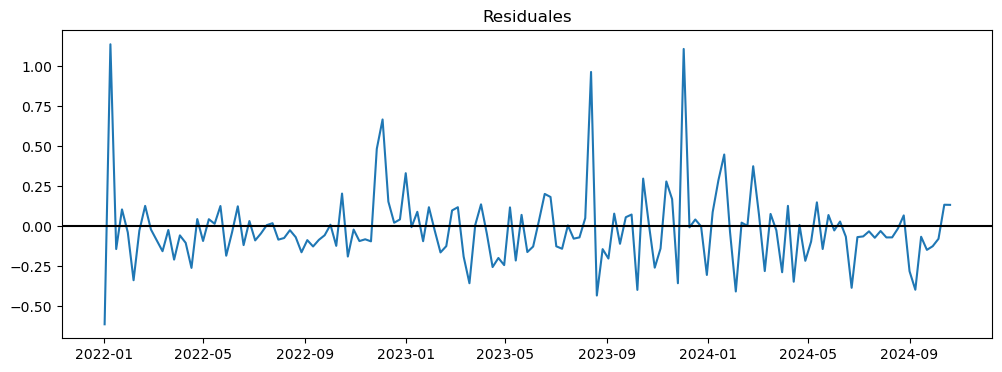

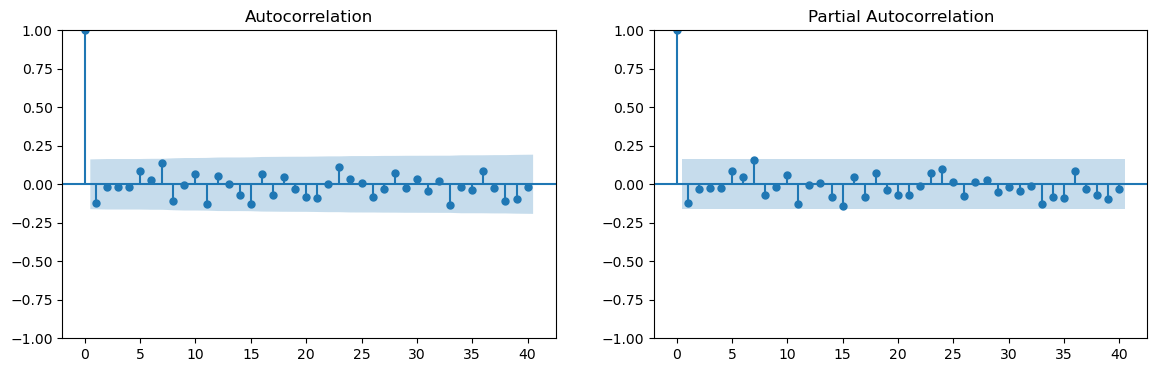

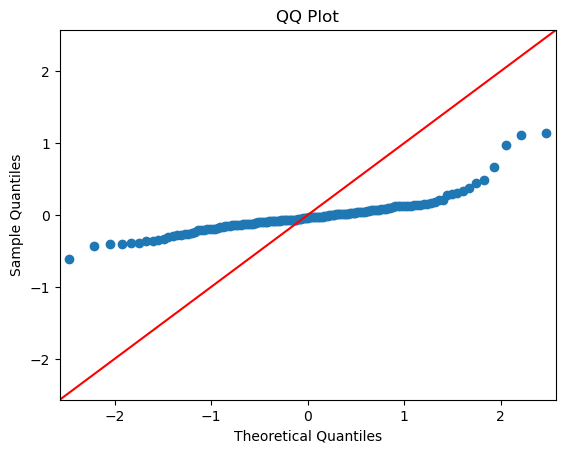

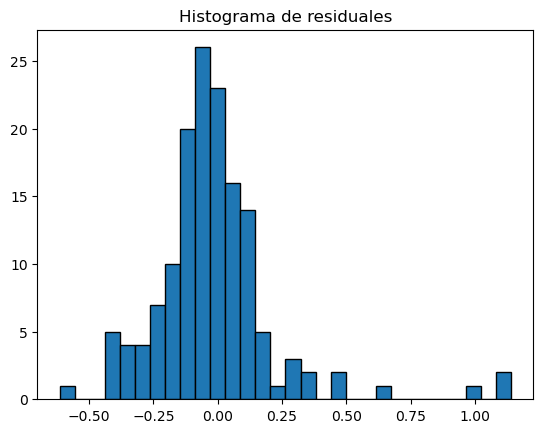

In [53]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "Y_3", y_transform=None, inverse_transform=None)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)


## Y_4 (SO2)

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: -948.6330585767315
MAE: 1.4491980957761759
RMSE: 2.1135877211590137
MAPE: 31.935381356776478
R2: 0.004654347516729995
LjungBox_p: 4.840490884955569e-07
JarqueBera_p: 0.0
best_order: (5, 1, 5)
  Variable      Coef  AbsImpact        Pvalue
1       RH -0.051617   0.051617  3.279451e-10
2       SR  0.016179   0.016179  9.434218e-02
4      WSR  0.016136   0.016136  6.210195e-03
0     TOUT  0.010751   0.010751  4.435948e-01
3      PRS -0.006050   0.006050  4.914095e-01
5      WDR  0.005642   0.005642  2.672389e-01
                               SARIMAX Results                                
Dep. Variable:                    Y_4   No. Observations:                 1021
Model:               SARIMAX(5, 1, 5)   Log Likelihood                 491.317
Date:                Fri, 05 Dec 2025   AIC                           -948.633
Time:                        07:54:57   BIC                           -864.965
Sample:                    01-01-2022   HQIC          

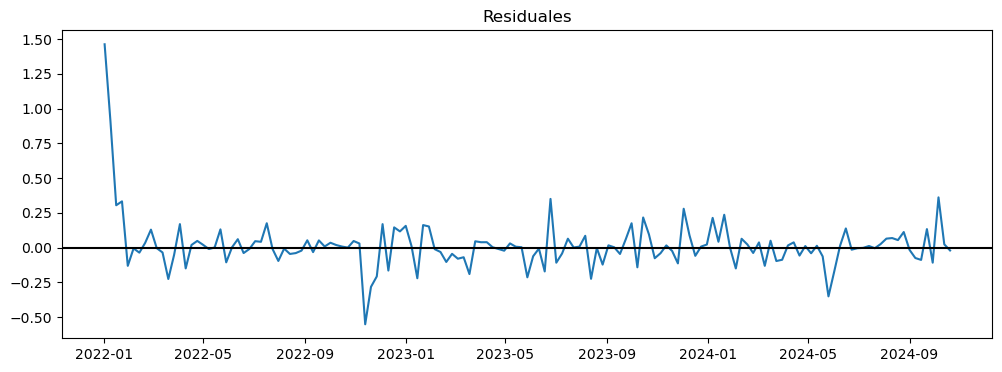

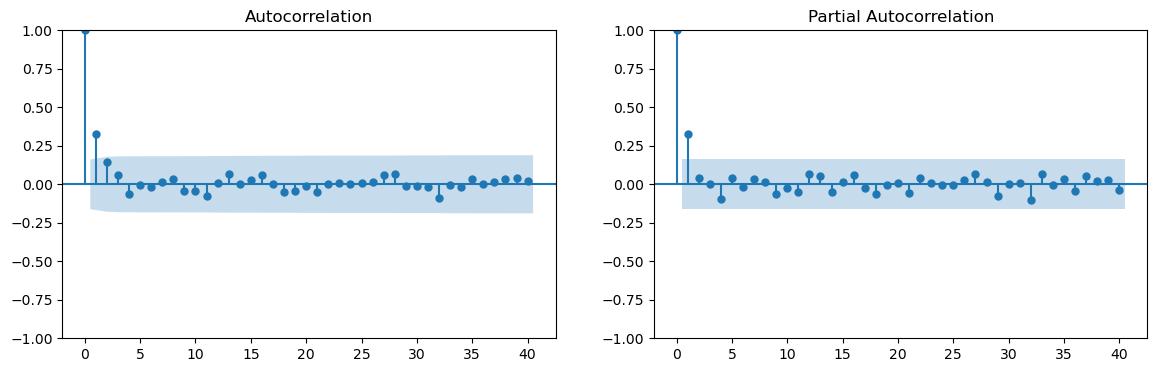

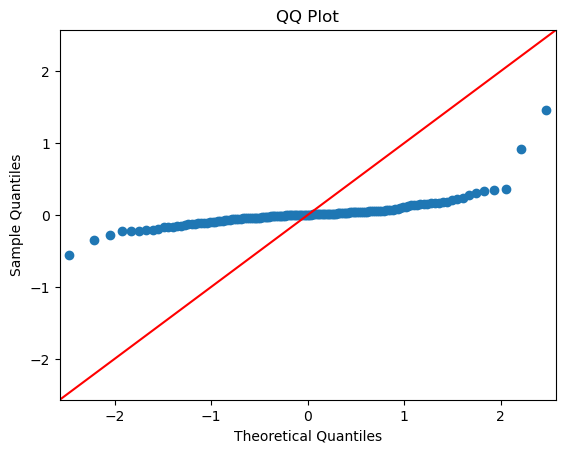

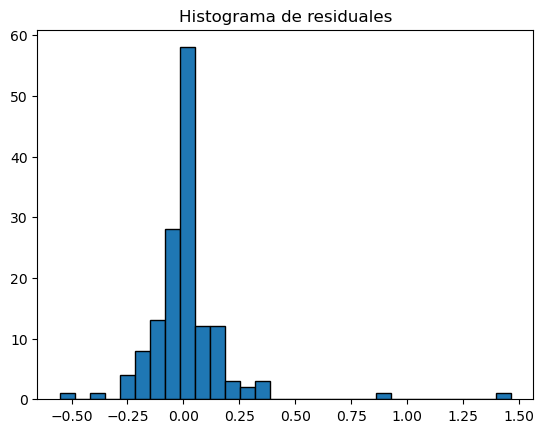

In [7]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "Y_4", y_transform=np.log1p, inverse_transform=np.expm1)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

# SUROESTE 2

## data

In [17]:
SUROESTE2 = pd.read_csv("df_SUROESTE2_22_25.csv").drop(columns=["CO"])
SUROESTE2["PM10_std"] = (SUROESTE2["PM10"] - SUROESTE2["PM10"].mean()) / SUROESTE2["PM10"].std()
SUROESTE2["PM2.5_std"] = (SUROESTE2["PM2.5"] - SUROESTE2["PM2.5"].mean()) / SUROESTE2["PM2.5"].std()
SUROESTE2["NO_std"] = (SUROESTE2["NO"] - SUROESTE2["NO"].mean()) / SUROESTE2["NO"].std()
SUROESTE2["NO2_std"] = (SUROESTE2["NO2"] - SUROESTE2["NO2"].mean()) / SUROESTE2["NO2"].std()
SUROESTE2["SO2_std"] = (SUROESTE2["SO2"] - SUROESTE2["SO2"].mean()) / SUROESTE2["SO2"].std()
SUROESTE2["O3_std"] = (SUROESTE2["O3"] - SUROESTE2["O3"].mean()) / SUROESTE2["O3"].std()  # Agrega estandarización de O3

# Crear los grupos Y en 'centro', incluyendo la fecha de captura
SUROESTE2["Y_1"] = SUROESTE2["O3_std"]
SUROESTE2["PM10"] = SUROESTE2["PM10"]
SUROESTE2["PM2.5"] = SUROESTE2["PM2.5"]
SUROESTE2["Y_3"] = SUROESTE2[["NO_std", "NO2_std"]].mean(axis=1)
SUROESTE2["Y_4"] = SUROESTE2["SO2"] 
# Incluye la columna "date" en el DataFrame resultado
SUROESTE2_Y = SUROESTE2[["date", "Y_1", "PM10", "PM2.5", "Y_3", "Y_4","TOUT", "RH", "SR", "PRS", "WSR", "WDR"]]


# --- Diario: ozono ('Y_1') con máximo, el resto con promedio ---
df_SUROESTE2_diario = SUROESTE2_Y.copy()
df_SUROESTE2_diario['date'] = pd.to_datetime(df_SUROESTE2_diario['date'])
df_SUROESTE2_diario = df_SUROESTE2_diario.set_index('date')
df_Y_diario = df_SUROESTE2_diario.resample("D").mean()

# --- Semanal: ozono ('Y_1') con máximo semanal, resto promedio ---
df_SUROESTE2_semanal = SUROESTE2_Y.copy()
df_SUROESTE2_semanal['date'] = pd.to_datetime(df_SUROESTE2_semanal['date'])
df_SUROESTE2_semanal = df_SUROESTE2_semanal.set_index('date')
df_Y_semanal = df_SUROESTE2_semanal.resample("W").mean()
df_Y_semanal.describe().T


,count,mean,std,min,25%,50%,75%,max
Y_1,184.0,-0.001820,0.442678,-0.974319,-0.273415,-0.039743,0.246792,1.268138
PM10,184.0,64.688000,39.213533,25.791667,48.313244,59.490744,72.407738,521.679345
PM2.5,184.0,18.026361,5.419464,7.500000,14.020833,17.162202,21.473244,41.181548
Y_3,184.0,-0.004329,0.437963,-0.643342,-0.347642,-0.129857,0.270746,1.509425
Y_4,184.0,4.475510,1.222788,1.720833,3.580134,4.304167,5.277530,8.610714
TOUT,184.0,22.845580,5.805539,7.508631,18.809122,23.884911,27.800937,33.241845
RH,184.0,53.462770,11.704201,17.315476,46.557314,53.616071,62.095238,85.422619
SR,184.0,0.166014,0.054087,0.047024,0.121074,0.167738,0.210833,0.269048
PRS,184.0,713.831819,1.019619,711.463095,713.128274,713.768155,714.458631,716.541071
WSR,184.0,-2.830623,5.765522,-15.280595,-7.596042,-3.047411,3.204613,8.170301


## Y_1 (Ozono)

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 345.3395940325213
MAE: 0.3241988080952791
RMSE: 0.3939111971520958
MAPE: 153.55603482209227
R2: 0.5082795488348025
LjungBox_p: 0.2951818662034459
JarqueBera_p: 6.100331545461569e-28
best_order: (3, 0, 5)
  Variable      Coef  AbsImpact        Pvalue
1       RH -0.205813   0.205813  1.460478e-33
2       SR  0.103174   0.103174  1.175007e-19
4      WSR -0.067761   0.067761  3.557037e-06
0     TOUT  0.064552   0.064552  6.424231e-02
3      PRS  0.034368   0.034368  7.922838e-02
5      WDR  0.032808   0.032808  4.059207e-02
                               SARIMAX Results                                
Dep. Variable:                    Y_1   No. Observations:                 1021
Model:               SARIMAX(3, 0, 5)   Log Likelihood                -157.670
Date:                Fri, 05 Dec 2025   AIC                            345.340
Time:                        07:03:39   BIC                            419.179
Sample:                    01-01-2022   HQ

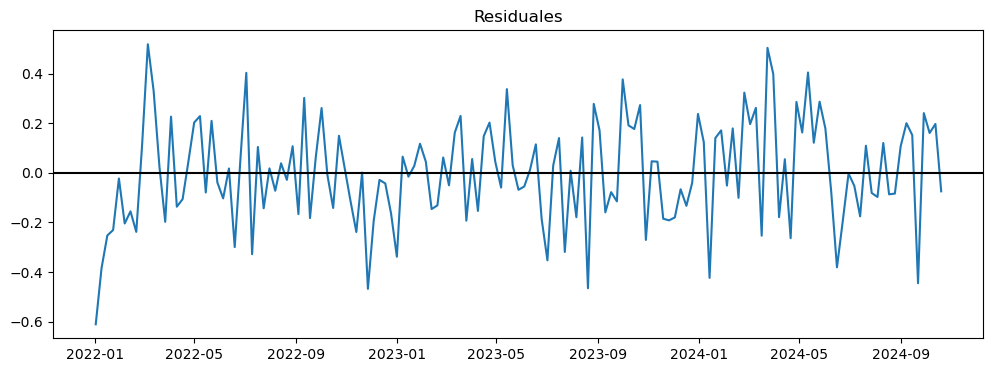

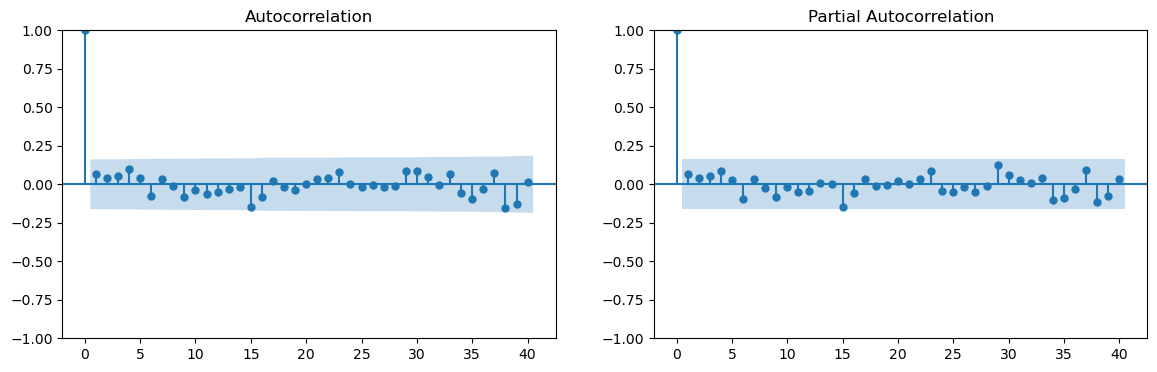

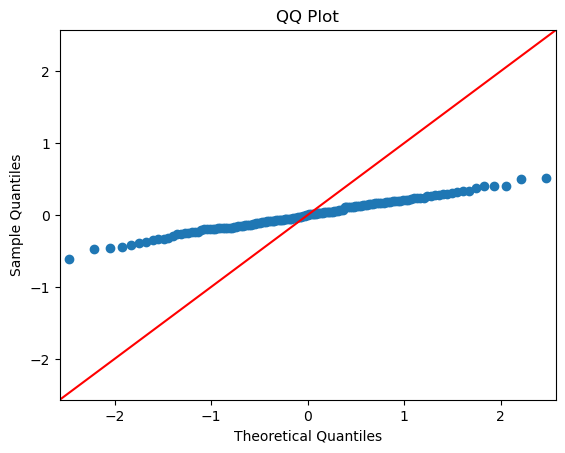

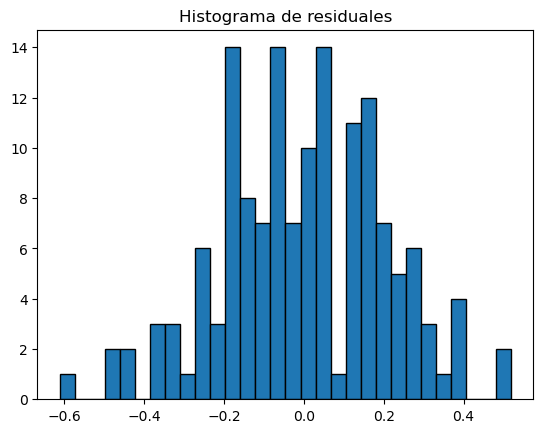

In [62]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "Y_1", y_transform=None, inverse_transform=None)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

## PM10

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 355.4121924534329
MAE: 21.259733829012646
RMSE: 32.3143722049684
MAPE: 33.810497512683796
R2: -0.41284578820351436
LjungBox_p: 0.12770751494660518
JarqueBera_p: 0.0
best_order: (5, 1, 3)
  Variable      Coef  AbsImpact        Pvalue
3      PRS -0.124036   0.124036  5.067680e-14
0     TOUT  0.097215   0.097215  1.066428e-03
4      WSR  0.069618   0.069618  5.259326e-07
5      WDR -0.043418   0.043418  1.851728e-03
2       SR  0.016436   0.016436  3.240149e-01
1       RH -0.010378   0.010378  4.644865e-01
                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1021
Model:               SARIMAX(5, 1, 3)   Log Likelihood                -162.706
Date:                Fri, 05 Dec 2025   AIC                            355.412
Time:                        08:15:54   BIC                            429.252
Sample:                    01-01-2022   HQIC               

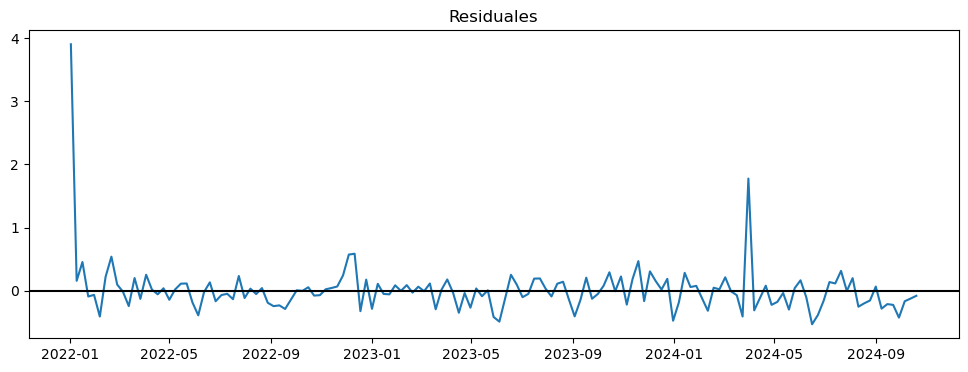

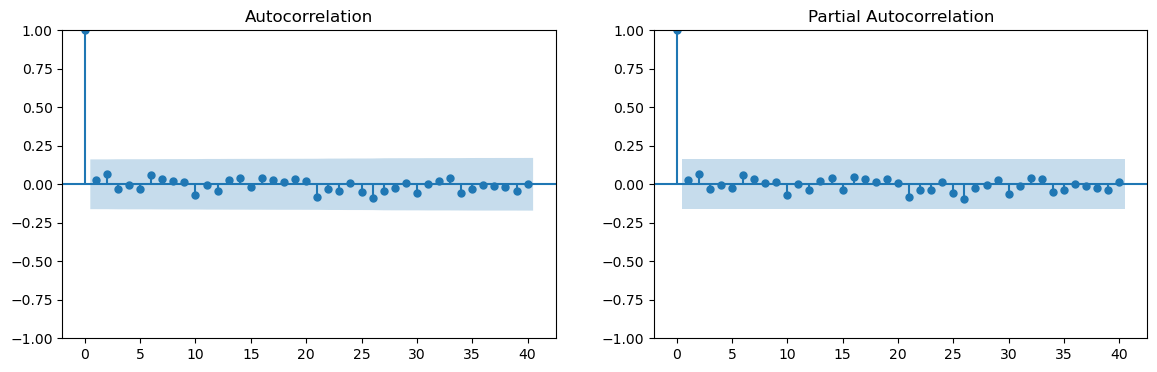

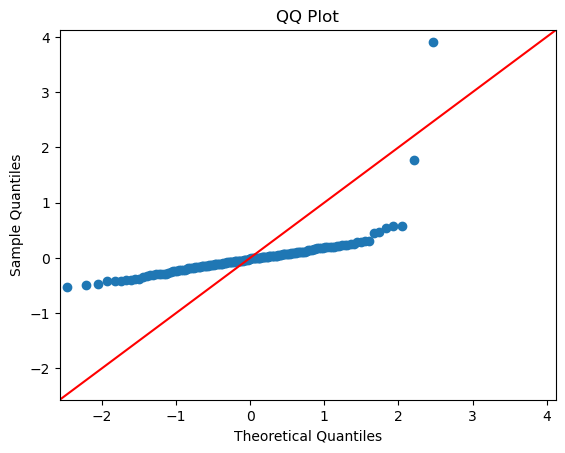

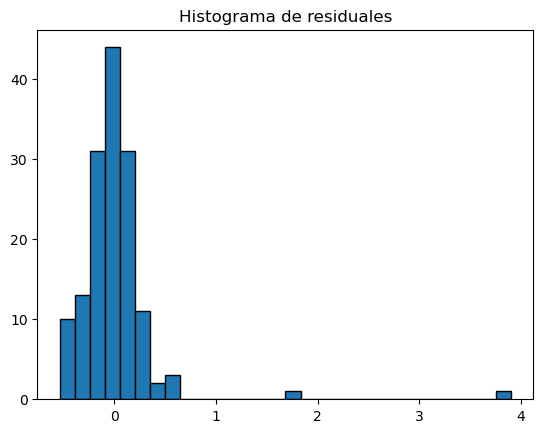

In [19]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "PM10", y_transform=np.log1p, inverse_transform=np.expm1)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

## PM2.5

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 261.79917528347255
MAE: 8.018496265820362
RMSE: 10.377365744227452
MAPE: 37.94228517133573
R2: -0.8043580703774158
LjungBox_p: 0.9862347341067903
JarqueBera_p: 0.0
best_order: (1, 1, 3)
  Variable      Coef  AbsImpact        Pvalue
1       RH  0.146377   0.146377  3.534875e-23
3      PRS -0.144270   0.144270  4.038487e-18
0     TOUT  0.108520   0.108520  8.476877e-05
4      WSR  0.074857   0.074857  3.303964e-08
2       SR  0.050779   0.050779  5.085912e-04
5      WDR -0.035815   0.035815  5.506214e-03
                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1021
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -119.900
Date:                Fri, 05 Dec 2025   AIC                            261.799
Time:                        08:21:58   BIC                            315.959
Sample:                    01-01-2022   HQIC                

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


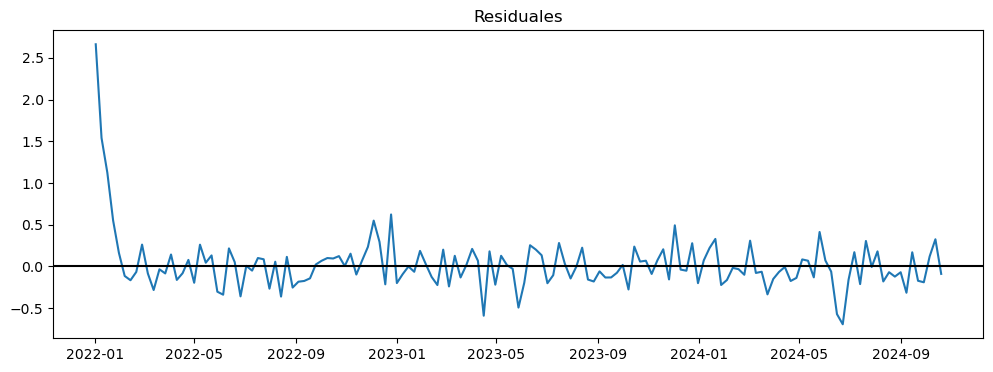

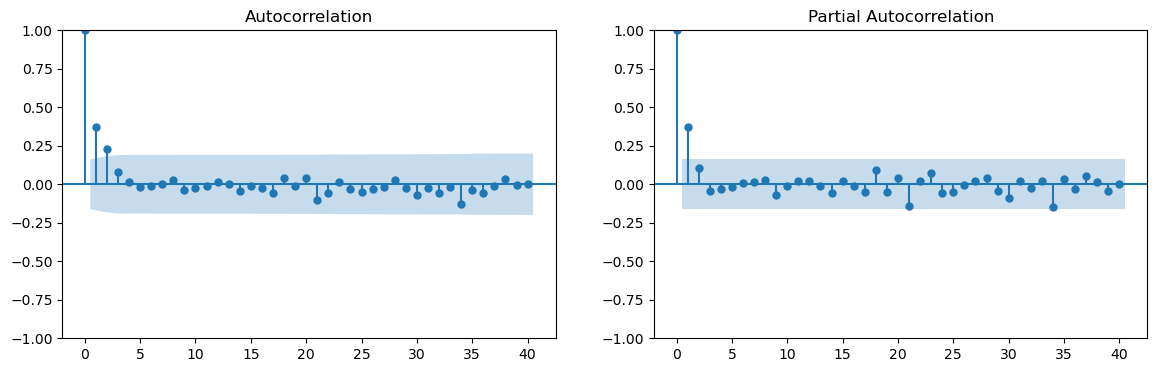

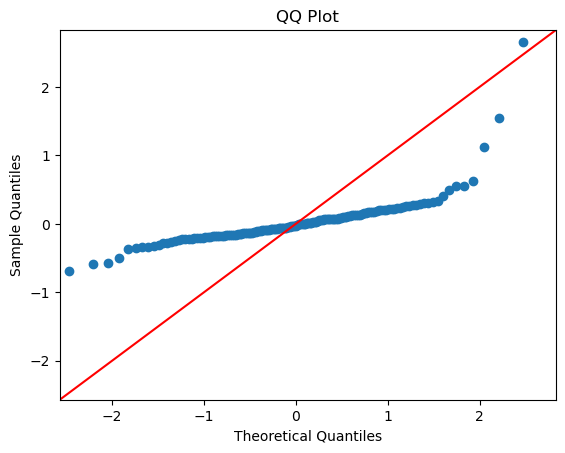

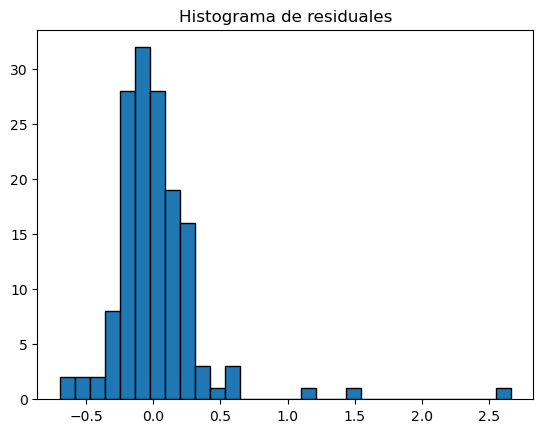

In [23]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "PM2.5", y_transform=np.log1p, inverse_transform=np.expm1)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

## Y_3 (Nitrogeno)

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 903.72690991995
MAE: 0.41347627842933643
RMSE: 0.5417981588072093
MAPE: 204.7474687616994
R2: 0.1226059649470439
LjungBox_p: 0.5860468765675926
JarqueBera_p: 0.0
best_order: (3, 0, 5)
  Variable      Coef  AbsImpact        Pvalue
3      PRS -0.217620   0.217620  2.851316e-19
0     TOUT -0.153117   0.153117  4.134799e-04
4      WSR  0.131754   0.131754  5.981656e-07
5      WDR -0.065900   0.065900  6.096517e-04
2       SR -0.028894   0.028894  1.694278e-01
1       RH  0.025672   0.025672  2.734365e-01
                               SARIMAX Results                                
Dep. Variable:                    Y_3   No. Observations:                 1021
Model:               SARIMAX(3, 0, 5)   Log Likelihood                -436.863
Date:                Fri, 05 Dec 2025   AIC                            903.727
Time:                        07:08:31   BIC                            977.567
Sample:                    01-01-2022   HQIC                  

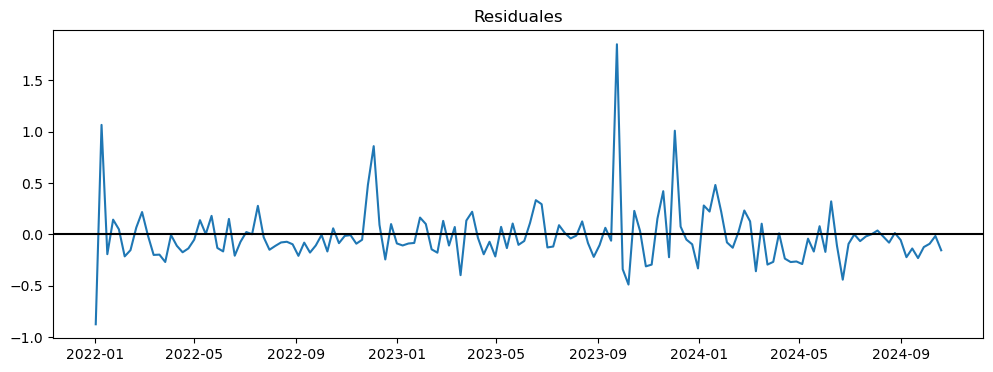

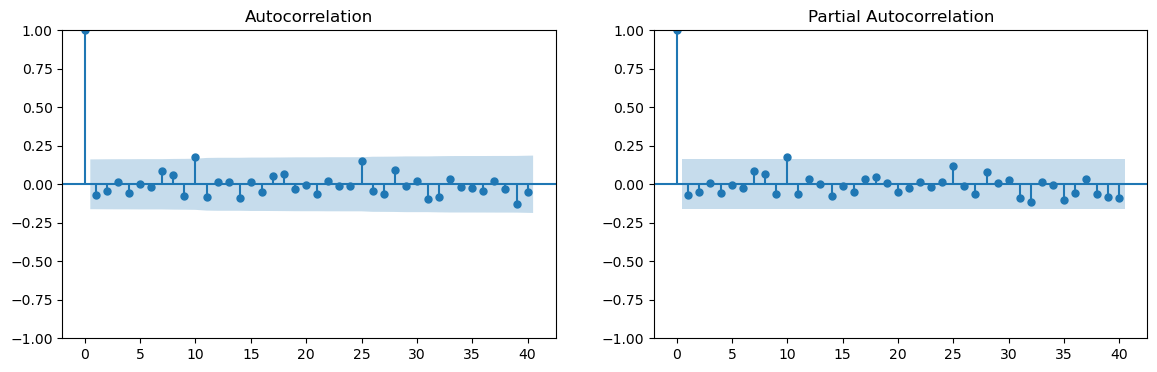

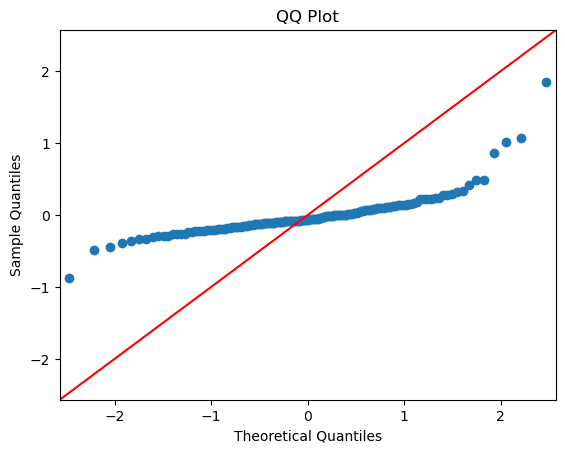

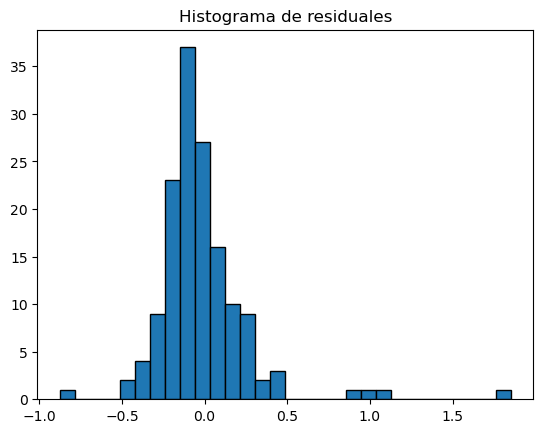

In [64]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "Y_3", y_transform=None, inverse_transform=None)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

## Y_4 (SO2)

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: -866.2154668628232
MAE: 1.4683785332854753
RMSE: 2.1907328692553207
MAPE: 24.340141617854158
R2: -0.3881818061715976
LjungBox_p: 0.4235092906615231
JarqueBera_p: 0.0
best_order: (4, 1, 4)
  Variable      Coef  AbsImpact        Pvalue
1       RH -0.055130   0.055130  5.834383e-10
3      PRS -0.047617   0.047617  6.262667e-07
4      WSR  0.019235   0.019235  4.329375e-02
2       SR  0.014454   0.014454  1.609573e-01
5      WDR  0.007024   0.007024  4.615533e-01
0     TOUT -0.005604   0.005604  7.367090e-01
                               SARIMAX Results                                
Dep. Variable:                    Y_4   No. Observations:                 1021
Model:               SARIMAX(4, 1, 4)   Log Likelihood                 448.108
Date:                Fri, 05 Dec 2025   AIC                           -866.215
Time:                        08:19:53   BIC                           -792.376
Sample:                    01-01-2022   HQIC              

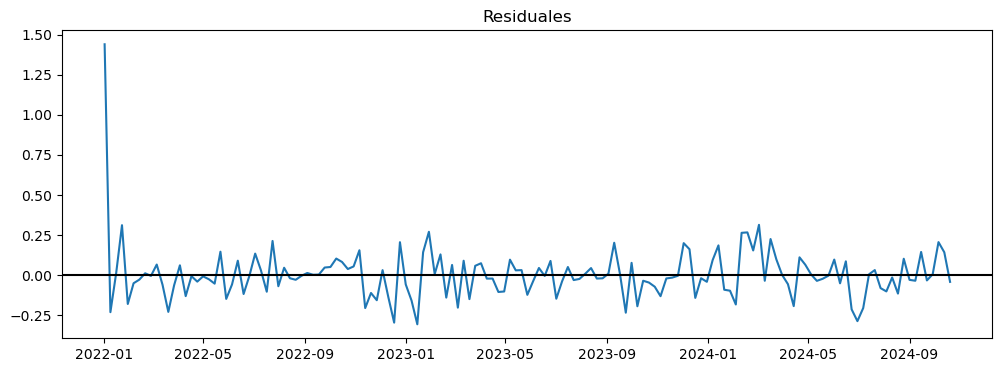

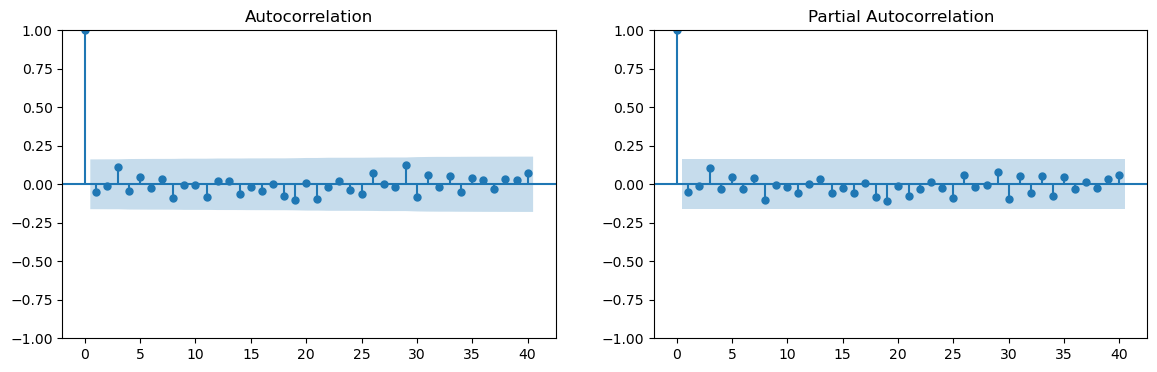

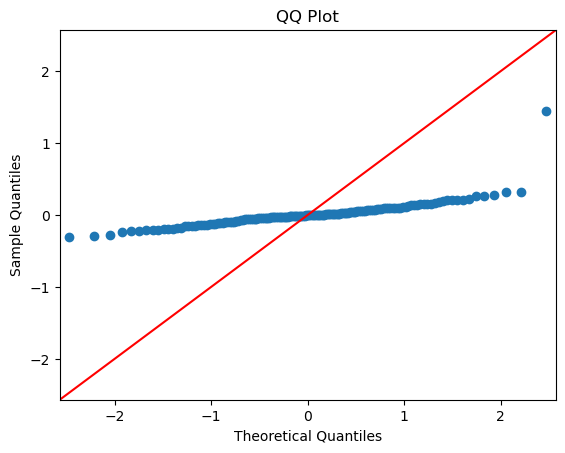

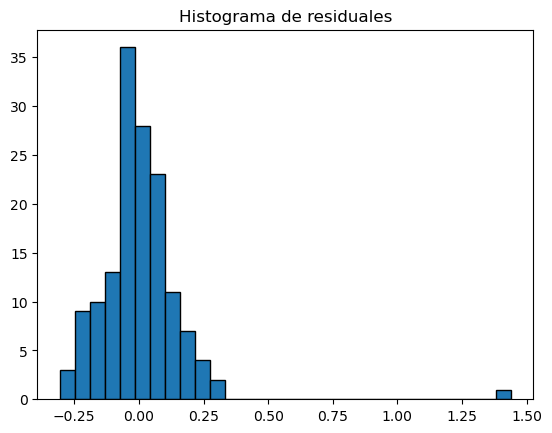

In [22]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "Y_4", y_transform=np.log1p, inverse_transform=np.expm1)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

# NORTE 2

## DATA

In [24]:
NORTE2 = pd.read_csv("df_NORTE2_22_25.csv").drop(columns=["CO"])
NORTE2["PM10_std"] = (NORTE2["PM10"] - NORTE2["PM10"].mean()) / NORTE2["PM10"].std()
NORTE2["PM2.5_std"] = (NORTE2["PM2.5"] - NORTE2["PM2.5"].mean()) / NORTE2["PM2.5"].std()
NORTE2["NO_std"] = (NORTE2["NO"] - NORTE2["NO"].mean()) / NORTE2["NO"].std()
NORTE2["NO2_std"] = (NORTE2["NO2"] - NORTE2["NO2"].mean()) / NORTE2["NO2"].std()
NORTE2["SO2_std"] = (NORTE2["SO2"] - NORTE2["SO2"].mean()) / NORTE2["SO2"].std()
NORTE2["O3_std"] = (NORTE2["O3"] - NORTE2["O3"].mean()) / NORTE2["O3"].std()  # Agrega estandarización de O3

# Crear los grupos Y en 'centro', incluyendo la fecha de captura
NORTE2["Y_1"] = NORTE2["O3_std"]
NORTE2["PM10"] = NORTE2["PM10"]
NORTE2["PM2.5"] = NORTE2["PM2.5"]
NORTE2["Y_3"] = NORTE2[["NO_std", "NO2_std"]].mean(axis=1)
NORTE2["Y_4"] = NORTE2["SO2"] 
# Incluye la columna "date" en el DataFrame resultado
NORTE2_Y = NORTE2[["date", "Y_1", "PM10", "PM2.5", "Y_3", "Y_4","TOUT", "RH", "SR", "PRS", "WSR", "WDR"]]


# --- Diario: ozono ('Y_1') con máximo, el resto con promedio ---
df_NORTE2_diario = NORTE2_Y.copy()
df_NORTE2_diario['date'] = pd.to_datetime(df_NORTE2_diario['date'])
df_NORTE2_diario = df_NORTE2_diario.set_index('date')
df_Y_diario = df_NORTE2_diario.resample("D").mean()

# --- Semanal: ozono ('Y_1') con máximo semanal, resto promedio ---
df_NORTE2_semanal = NORTE2_Y.copy()
df_NORTE2_semanal['date'] = pd.to_datetime(df_NORTE2_semanal['date'])
df_NORTE2_semanal = df_NORTE2_semanal.set_index('date')
df_Y_semanal = df_NORTE2_semanal.resample("W").mean()
df_Y_semanal.describe().T

,count,mean,std,min,25%,50%,75%,max
Y_1,184.0,-0.002786,0.391885,-1.051005,-0.235762,-0.050864,0.232745,1.107350
PM10,184.0,66.575795,21.683259,20.291667,50.209077,64.273810,80.118304,155.553571
PM2.5,184.0,20.184154,6.177195,7.500000,16.158482,19.242560,22.796131,46.333333
Y_3,184.0,-0.004226,0.522349,-0.816333,-0.446707,-0.099710,0.380259,1.359988
Y_4,184.0,4.638304,1.358392,2.383333,3.667560,4.253452,5.709896,8.847917
TOUT,184.0,23.817043,5.766273,8.486607,19.889122,24.984613,28.650446,33.779643
RH,184.0,54.526519,11.086294,21.386905,47.601190,55.065476,62.519345,85.363095
SR,184.0,0.122974,0.040707,0.027798,0.089762,0.126429,0.157292,0.203571
PRS,184.0,712.717965,2.637694,706.847619,710.924851,712.562202,714.355804,720.259524
WSR,184.0,-4.722065,2.462139,-11.406488,-6.481205,-4.648988,-2.812366,3.065417


## Y_1

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 232.55968857695873
MAE: 0.34799270855878306
RMSE: 0.4182940977191583
MAPE: 121.46340428185911
R2: 0.3963860172118099
LjungBox_p: 0.3964766849358181
JarqueBera_p: 2.023924932064266e-15
best_order: (2, 0, 1)
  Variable      Coef  AbsImpact        Pvalue
1       RH -0.142495   0.142495  6.636553e-22
2       SR  0.121839   0.121839  5.515327e-14
4      WSR -0.084403   0.084403  9.547449e-15
0     TOUT -0.058357   0.058357  6.680272e-02
5      WDR  0.023648   0.023648  1.276116e-02
3      PRS -0.011343   0.011343  5.055726e-01
                               SARIMAX Results                                
Dep. Variable:                    Y_1   No. Observations:                 1021
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -106.280
Date:                Fri, 05 Dec 2025   AIC                            232.560
Time:                        07:21:13   BIC                            281.825
Sample:                    01-01-2022   

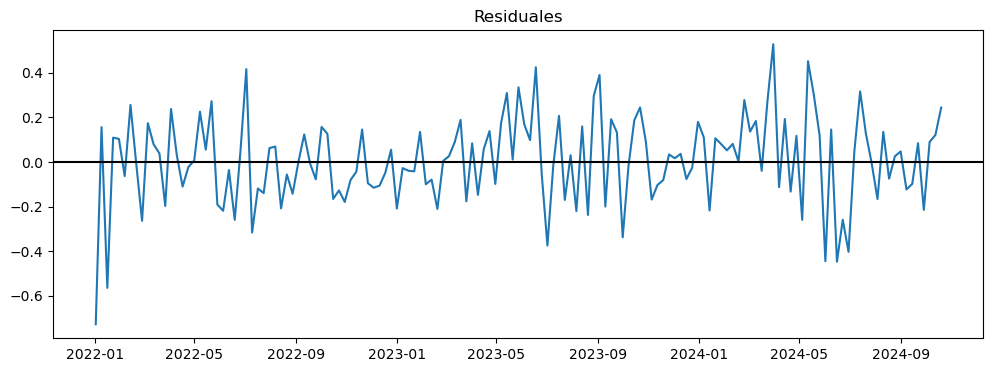

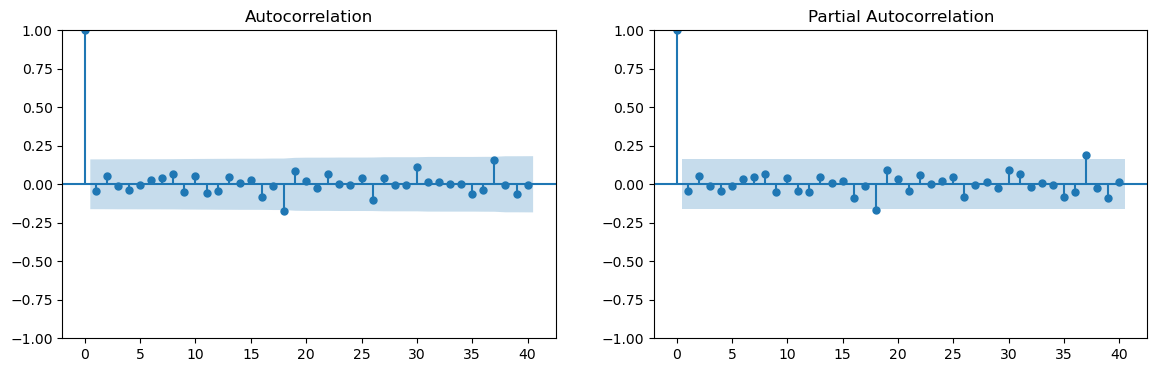

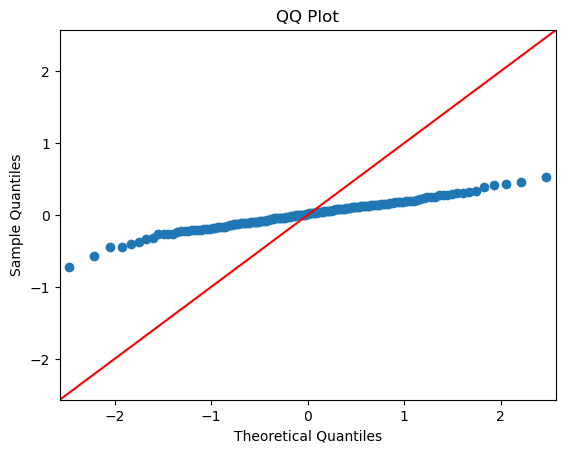

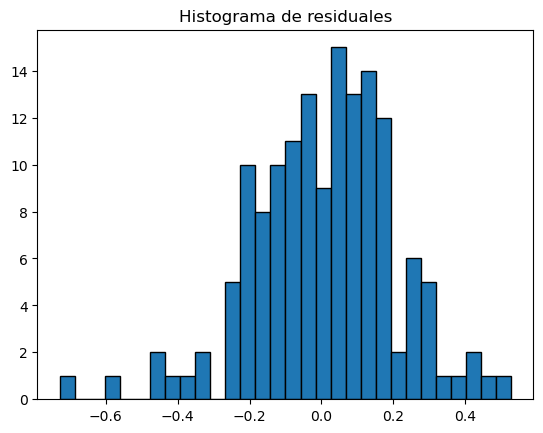

In [68]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "Y_1", y_transform=None, inverse_transform=None)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

## PM10

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 275.58089579793784
MAE: 25.84912249502183
RMSE: 34.44607573042068
MAPE: 41.04885731063146
R2: -0.10745930671931347
LjungBox_p: 0.0008659181540039678
JarqueBera_p: 0.0
best_order: (2, 1, 5)
  Variable      Coef  AbsImpact        Pvalue
0     TOUT  0.191824   0.191824  3.554007e-13
1       RH -0.087656   0.087656  1.517244e-09
3      PRS -0.079439   0.079439  1.052230e-07
4      WSR  0.071629   0.071629  1.420475e-11
2       SR  0.025593   0.025593  1.669862e-01
5      WDR -0.005429   0.005429  4.466935e-01
                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1021
Model:               SARIMAX(2, 1, 5)   Log Likelihood                -123.790
Date:                Fri, 05 Dec 2025   AIC                            275.581
Time:                        08:24:19   BIC                            344.484
Sample:                    01-01-2022   HQIC             

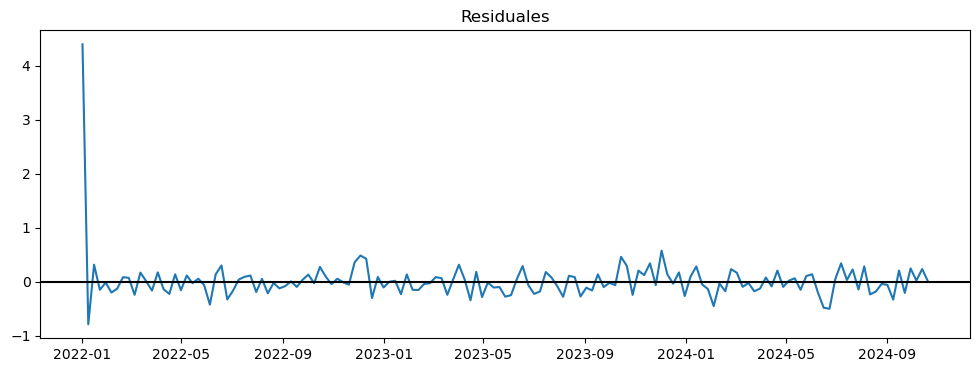

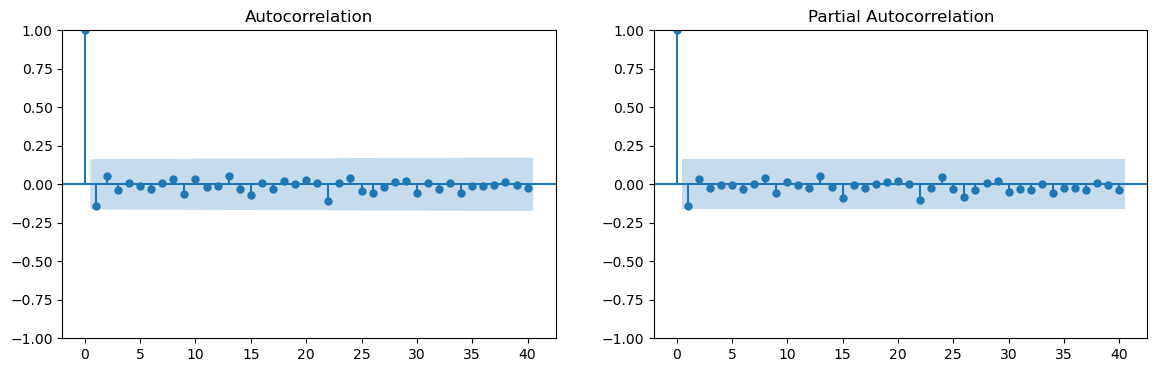

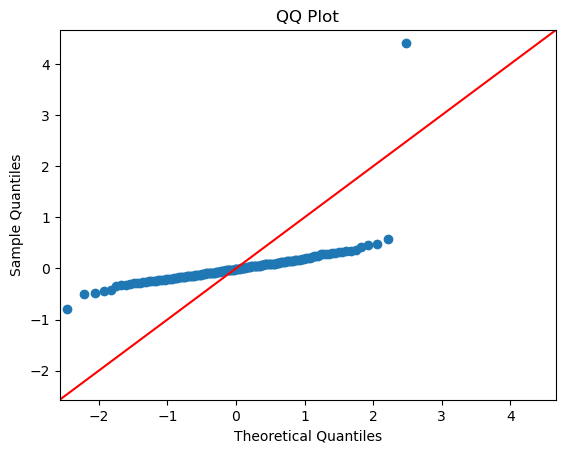

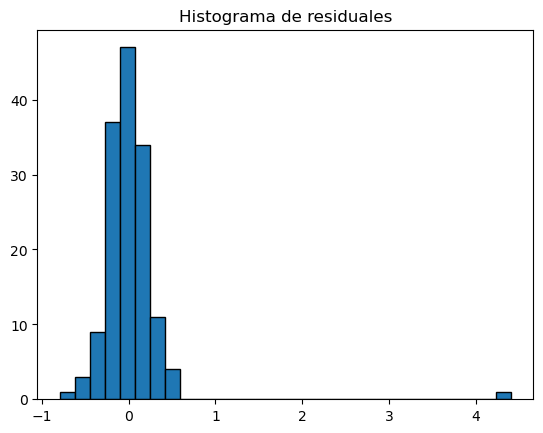

In [25]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "PM10", y_transform=np.log1p, inverse_transform=np.expm1)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

## PM2.5

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 382.63956647721056
MAE: 6.890106549316632
RMSE: 9.079253577029432
MAPE: 35.75596653516606
R2: -0.20346798316138504
LjungBox_p: 0.36244037228086523
JarqueBera_p: 0.0
best_order: (1, 1, 2)
  Variable      Coef  AbsImpact        Pvalue
0     TOUT  0.211950   0.211950  5.836808e-15
1       RH  0.109078   0.109078  3.402751e-13
3      PRS -0.103217   0.103217  6.220699e-10
5      WDR  0.080600   0.080600  2.368403e-19
4      WSR  0.059662   0.059662  1.199975e-06
2       SR  0.059199   0.059199  2.102766e-03
                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1021
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -181.320
Date:                Fri, 05 Dec 2025   AIC                            382.640
Time:                        08:27:55   BIC                            431.886
Sample:                    01-01-2022   HQIC               

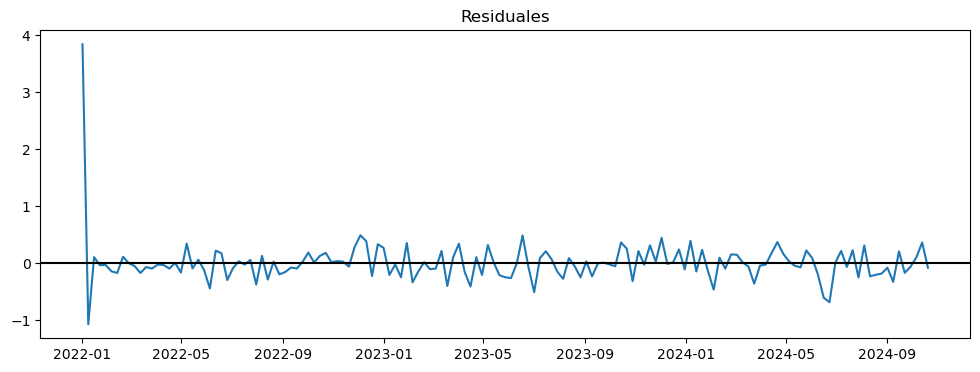

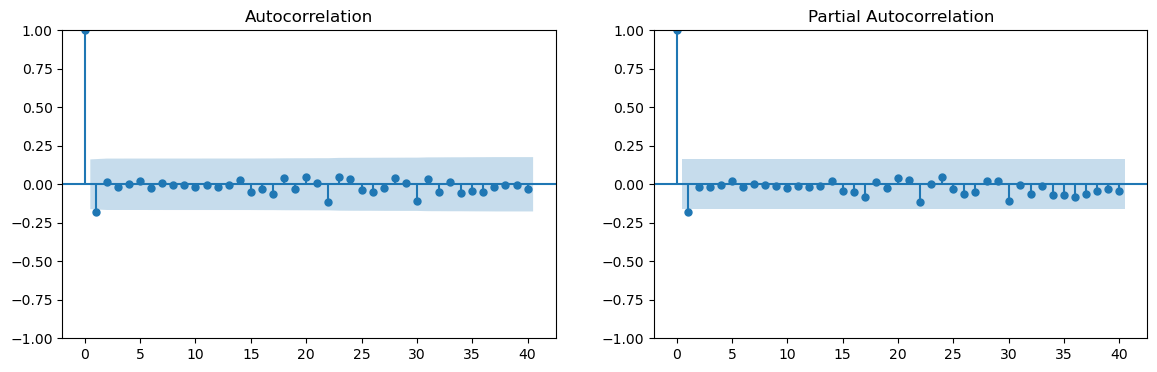

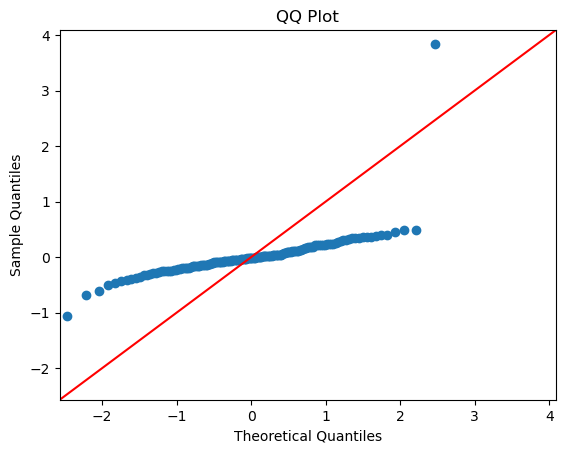

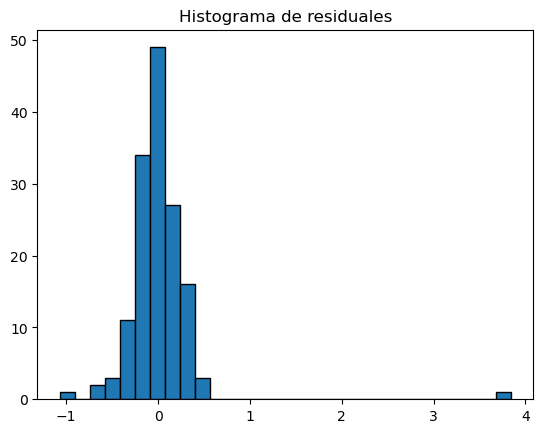

In [27]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "PM2.5", y_transform=np.log1p, inverse_transform=np.expm1)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

## Y_3

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 541.9828350717698
MAE: 0.5484652592568221
RMSE: 0.6949832819999935
MAPE: 149.5412210795301
R2: 0.2627417148325084
LjungBox_p: 0.0010210166413130686
JarqueBera_p: 3.883896929448926e-238
best_order: (5, 0, 5)
  Variable      Coef  AbsImpact        Pvalue
4      WSR  0.210370   0.210370  2.983932e-88
5      WDR  0.073539   0.073539  5.243861e-13
3      PRS -0.071246   0.071246  1.178294e-06
1       RH -0.065493   0.065493  1.518940e-05
0     TOUT -0.020427   0.020427  4.443714e-01
2       SR -0.016714   0.016714  4.322777e-01
                               SARIMAX Results                                
Dep. Variable:                    Y_3   No. Observations:                 1021
Model:               SARIMAX(5, 0, 5)   Log Likelihood                -253.991
Date:                Fri, 05 Dec 2025   AIC                            541.983
Time:                        07:22:48   BIC                            625.668
Sample:                    01-01-2022  

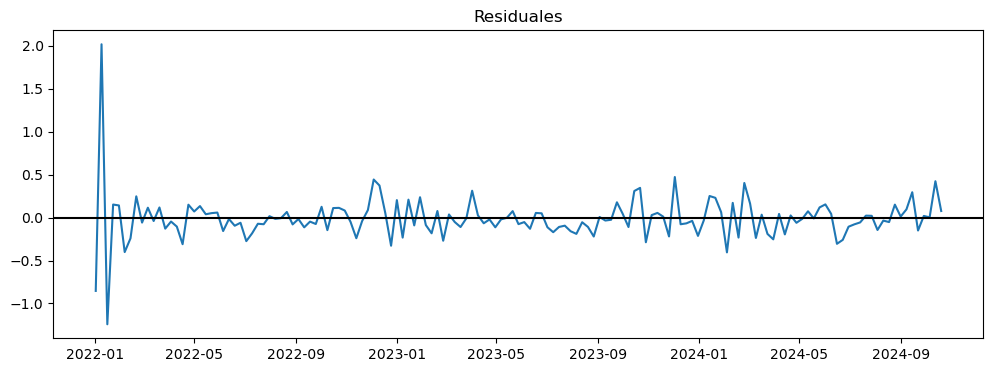

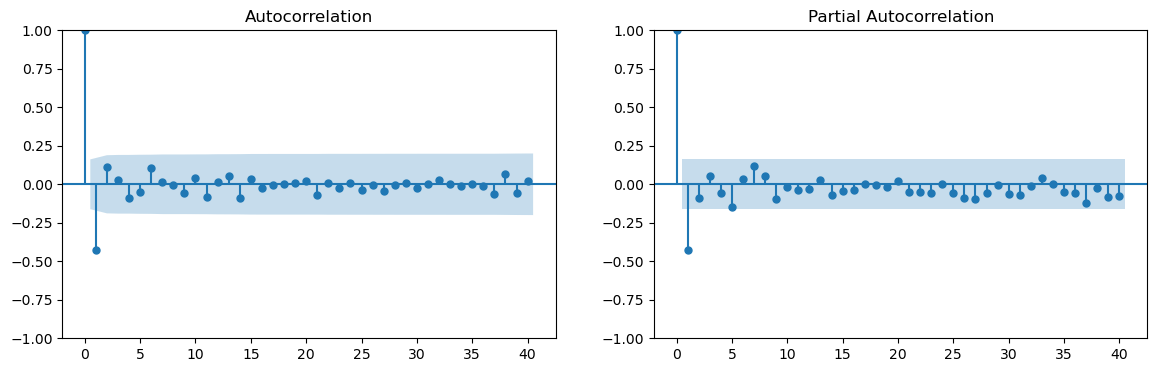

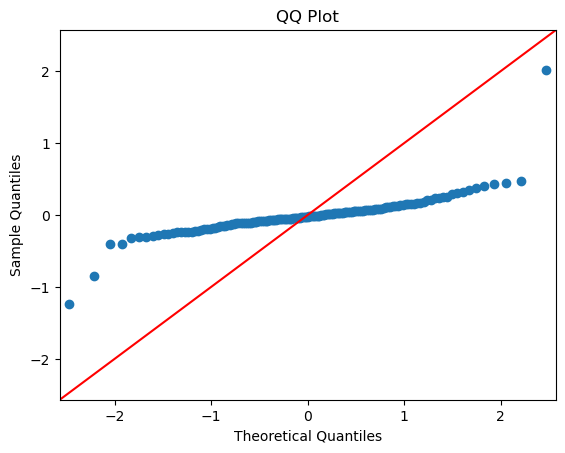

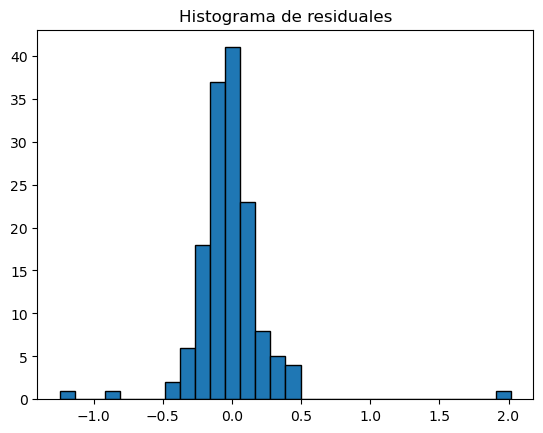

In [70]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "Y_3", y_transform=None, inverse_transform=None)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

## Y_4

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 2957.4530536008892
MAE: 0.7751689619135362
RMSE: 0.9615583653034434
MAPE: 20.700552607463774
R2: -0.6718360405858341
LjungBox_p: 0.06919115085473541
JarqueBera_p: 0.0
best_order: (5, 1, 5)
  Variable      Coef  AbsImpact        Pvalue
1       RH -0.397243   0.397243  1.602619e-10
5      WDR  0.237619   0.237619  5.032594e-08
3      PRS -0.161834   0.161834  1.260258e-02
2       SR -0.062351   0.062351  4.106897e-01
0     TOUT  0.052904   0.052904  6.290070e-01
4      WSR -0.005073   0.005073  9.207626e-01
                               SARIMAX Results                                
Dep. Variable:                    Y_4   No. Observations:                 1021
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -1461.727
Date:                Fri, 05 Dec 2025   AIC                           2957.453
Time:                        08:31:55   BIC                           3041.121
Sample:                    01-01-2022   HQIC             

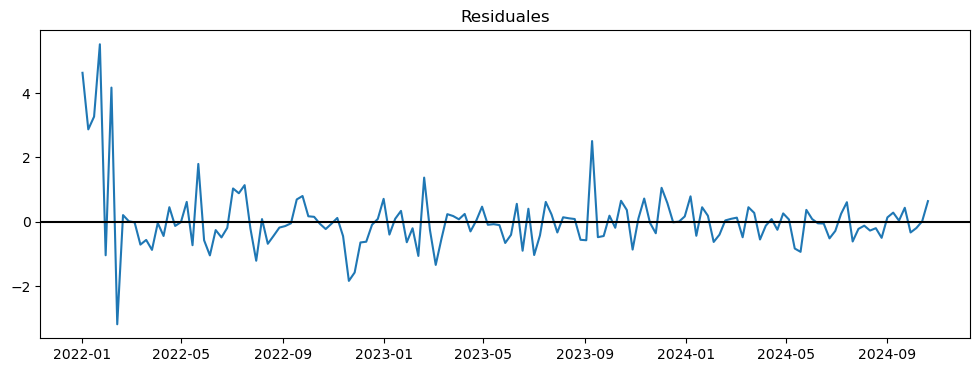

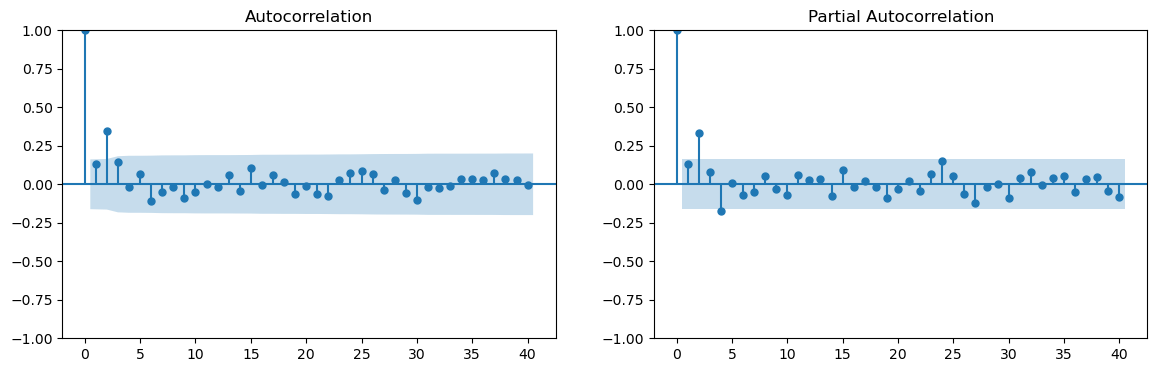

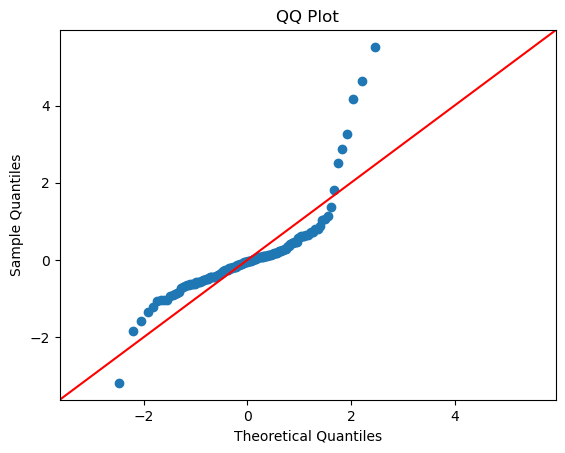

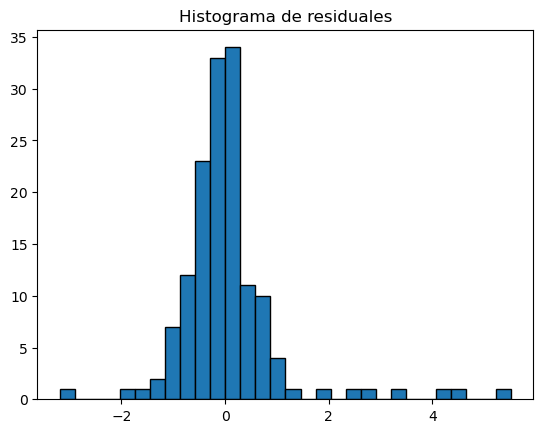

In [30]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "Y_4", y_transform=None, inverse_transform=None)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

# SURESTE3

## DATA

In [31]:
SURESTE3 = pd.read_csv("df_SURESTE3_22_25.csv").drop(columns=["CO"])
SURESTE3["PM10_std"] = (SURESTE3["PM10"] - SURESTE3["PM10"].mean()) / SURESTE3["PM10"].std()
SURESTE3["PM2.5_std"] = (SURESTE3["PM2.5"] - SURESTE3["PM2.5"].mean()) / SURESTE3["PM2.5"].std()
SURESTE3["NO_std"] = (SURESTE3["NO"] - SURESTE3["NO"].mean()) / SURESTE3["NO"].std()
SURESTE3["NO2_std"] = (SURESTE3["NO2"] - SURESTE3["NO2"].mean()) / SURESTE3["NO2"].std()
SURESTE3["SO2_std"] = (SURESTE3["SO2"] - SURESTE3["SO2"].mean()) / SURESTE3["SO2"].std()
SURESTE3["O3_std"] = (SURESTE3["O3"] - SURESTE3["O3"].mean()) / SURESTE3["O3"].std()  # Agrega estandarización de O3

# Crear los grupos Y en 'centro', incluyendo la fecha de captura
SURESTE3["Y_1"] = SURESTE3["O3_std"]
SURESTE3["PM10"] = SURESTE3["PM10"]
SURESTE3["PM2.5"] = SURESTE3["PM2.5"]
SURESTE3["Y_3"] = SURESTE3[["NO_std", "NO2_std"]].mean(axis=1)
SURESTE3["Y_4"] = SURESTE3["SO2"] 
# Incluye la columna "date" en el DataFrame resultado
SURESTE3_Y = SURESTE3[["date", "Y_1", "PM10", "PM2.5", "Y_3", "Y_4","TOUT", "RH", "SR", "PRS", "WSR", "WDR"]]


# --- Diario: ozono ('Y_1') con máximo, el resto con promedio ---
df_SURESTE3_diario = SURESTE3_Y.copy()
df_SURESTE3_diario['date'] = pd.to_datetime(df_SURESTE3_diario['date'])
df_SURESTE3_diario = df_SURESTE3_diario.set_index('date')
df_Y_diario = df_SURESTE3_diario.resample("D").mean()

# --- Semanal: ozono ('Y_1') con máximo semanal, resto promedio ---
df_SURESTE3_semanal = SURESTE3_Y.copy()
df_SURESTE3_semanal['date'] = pd.to_datetime(df_SURESTE3_semanal['date'])
df_SURESTE3_semanal = df_SURESTE3_semanal.set_index('date')
df_Y_semanal = df_SURESTE3_semanal.resample("W").mean()
df_Y_semanal.describe().T

,count,mean,std,min,25%,50%,75%,max
Y_1,184.0,-0.003322,0.388488,-1.033372,-0.247699,-0.018803,0.162394,1.133903
PM10,184.0,68.307322,24.305910,21.750000,49.427083,63.849702,82.555804,163.095238
PM2.5,184.0,20.518373,9.492211,7.191667,13.431548,18.217262,25.084077,57.383929
Y_3,184.0,-0.001839,0.484383,-0.581269,-0.383248,-0.126715,0.253310,1.571474
Y_4,184.0,6.708993,3.511275,2.316667,4.376042,6.230625,7.926339,27.434524
TOUT,184.0,23.614979,5.842768,8.346131,19.416667,24.799494,28.301622,32.891369
RH,184.0,59.695420,10.768387,22.369048,52.102679,59.901786,67.638393,87.869048
SR,184.0,0.148021,0.051548,0.030417,0.106429,0.151905,0.188170,0.277083
PRS,184.0,728.342952,5.025411,720.214881,723.423661,729.235119,731.689583,741.079762
WSR,184.0,-2.940963,3.203337,-12.996964,-4.680818,-2.075446,-0.707217,6.387292


## Y_1

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 323.62643524009496
MAE: 0.3271723882983883
RMSE: 0.41969390567115683
MAPE: 229.16267556036073
R2: 0.35938055087249465
LjungBox_p: 0.9526213980673802
JarqueBera_p: 1.9593966626670116e-31
best_order: (5, 0, 5)
  Variable      Coef  AbsImpact        Pvalue
1       RH -0.154046   0.154046  3.079840e-32
2       SR  0.091980   0.091980  2.161608e-09
0     TOUT -0.054706   0.054706  2.053122e-02
4      WSR -0.030756   0.030756  2.623260e-02
3      PRS -0.007531   0.007531  5.325965e-01
5      WDR  0.000372   0.000372  9.753394e-01
                               SARIMAX Results                                
Dep. Variable:                    Y_1   No. Observations:                 1021
Model:               SARIMAX(5, 0, 5)   Log Likelihood                -144.813
Date:                Fri, 05 Dec 2025   AIC                            323.626
Time:                        07:27:18   BIC                            407.311
Sample:                    01-01-2022 

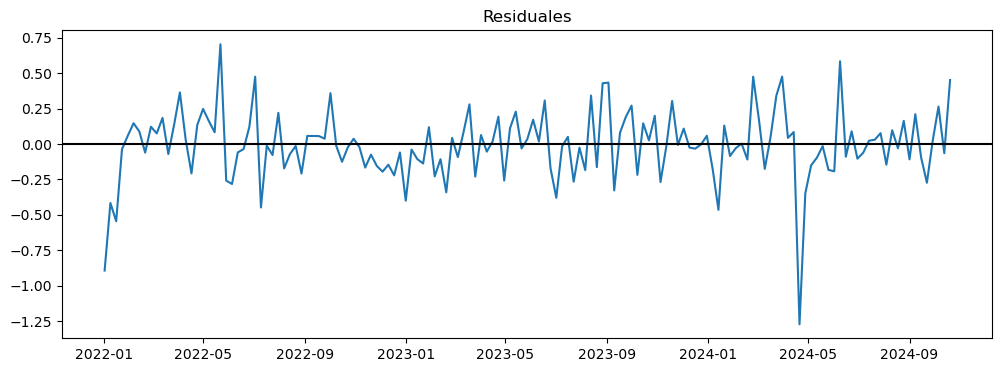

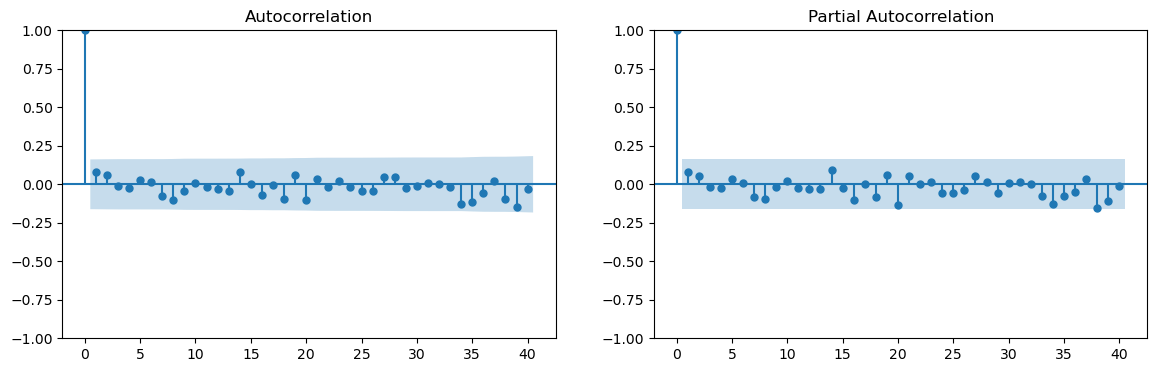

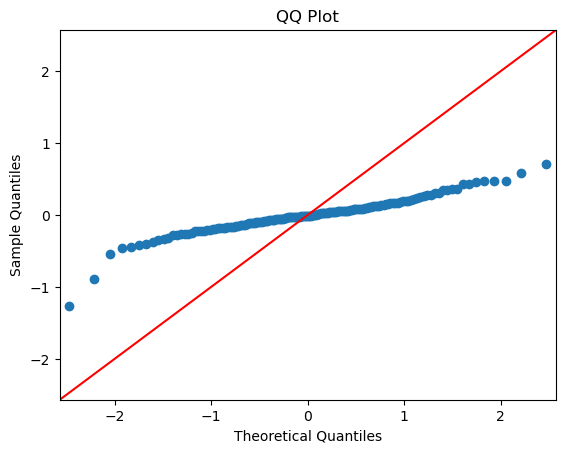

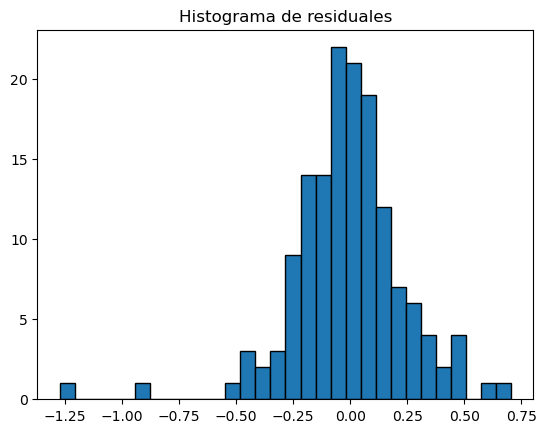

In [73]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "Y_1", y_transform=None, inverse_transform=None)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

## PM10

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 216.81852964508533
MAE: 34.98844948980857
RMSE: 44.95575011638834
MAPE: 63.57551685439676
R2: -0.2585020959186177
LjungBox_p: 0.7900234709424603
JarqueBera_p: 0.0
best_order: (4, 1, 1)
  Variable      Coef  AbsImpact        Pvalue
0     TOUT  0.307819   0.307819  2.671201e-40
1       RH -0.126651   0.126651  2.736492e-24
4      WSR  0.078329   0.078329  4.670847e-09
5      WDR  0.038386   0.038386  1.290823e-04
3      PRS -0.027562   0.027562  9.358670e-02
2       SR  0.021879   0.021879  1.502708e-01
                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1021
Model:               SARIMAX(4, 1, 1)   Log Likelihood                 -96.409
Date:                Fri, 05 Dec 2025   AIC                            216.819
Time:                        08:33:43   BIC                            275.902
Sample:                    01-01-2022   HQIC                 

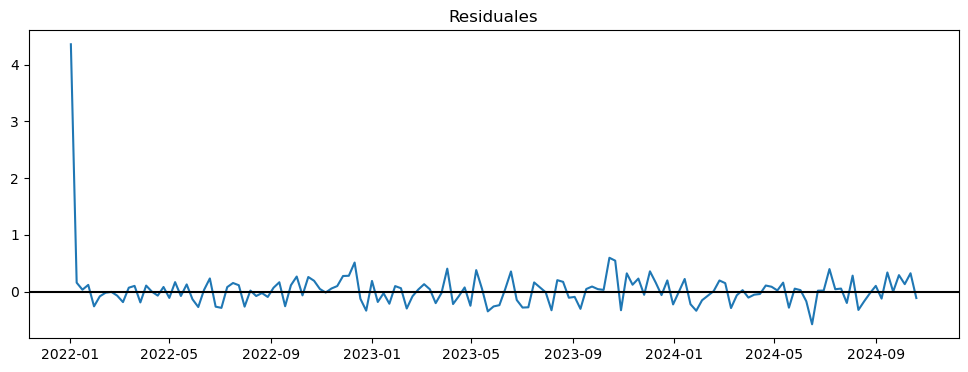

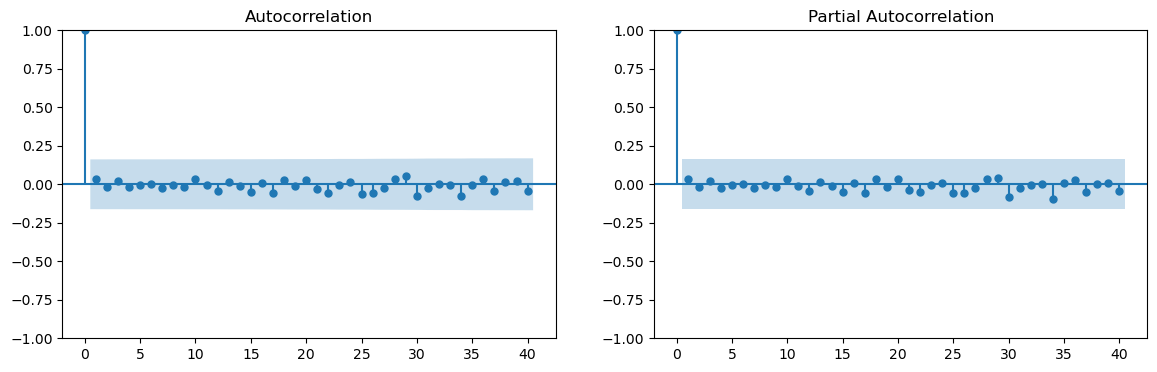

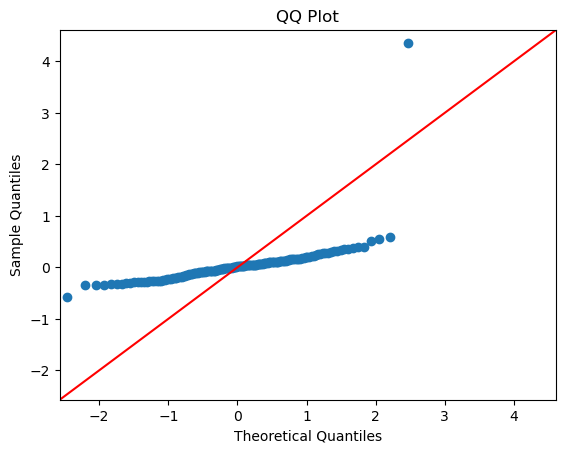

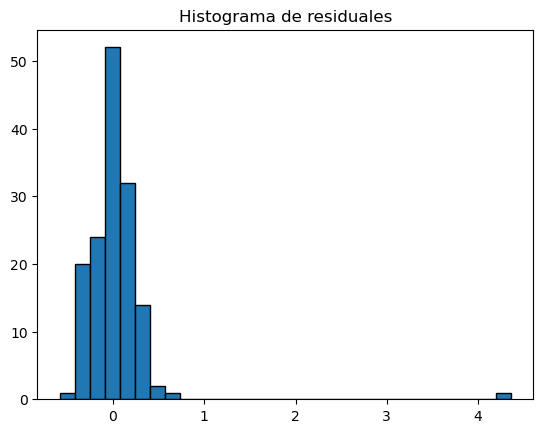

In [32]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "PM10", y_transform=np.log1p, inverse_transform=np.expm1)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

## PM2.5

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 7383.223440961566
MAE: 9.190715467061294
RMSE: 11.936277012707885
MAPE: 56.13940744892558
R2: -0.7552096297654465
LjungBox_p: 0.0783907149734467
JarqueBera_p: 0.0
best_order: (4, 1, 5)
  Variable      Coef  AbsImpact        Pvalue
0     TOUT  8.967145   8.967145  2.467496e-25
3      PRS -1.063212   1.063212  1.177332e-01
4      WSR  0.870783   0.870783  1.227814e-01
5      WDR  0.859381   0.859381  9.927807e-03
1       RH  0.436407   0.436407  4.437102e-01
2       SR  0.357714   0.357714  6.108972e-01
                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1021
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -3675.612
Date:                Fri, 05 Dec 2025   AIC                           7383.223
Time:                        08:35:16   BIC                           7461.970
Sample:                    01-01-2022   HQIC                 

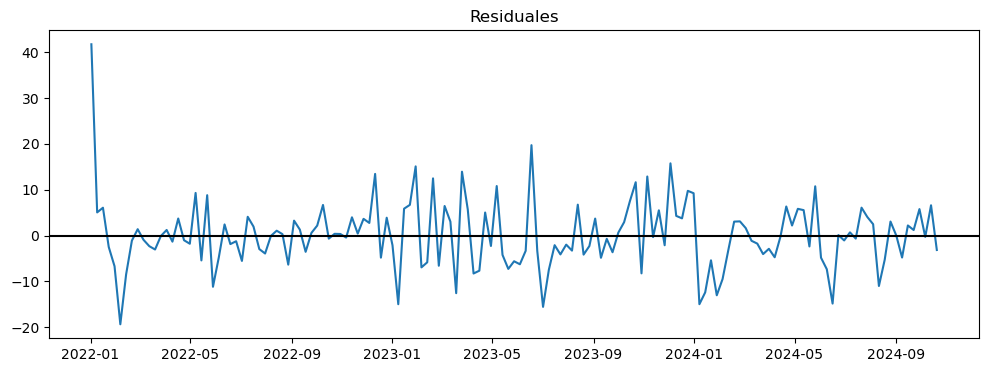

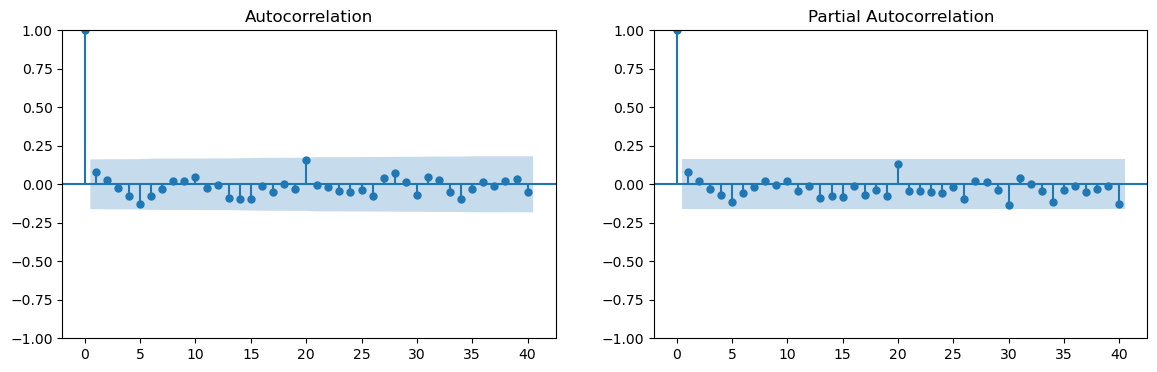

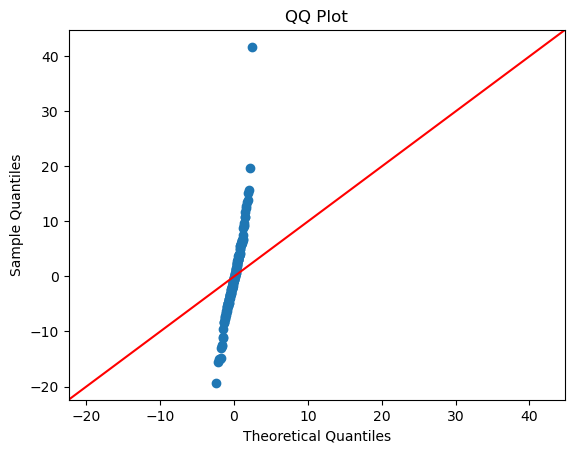

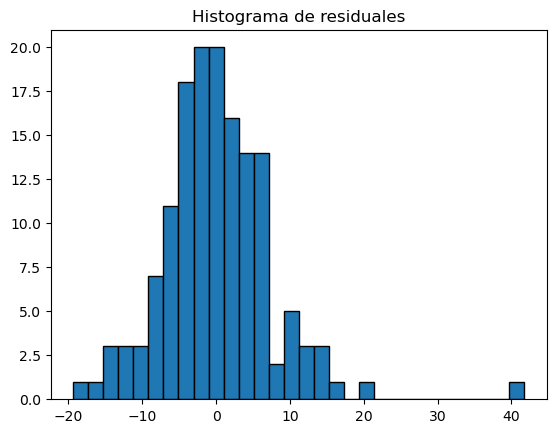

In [33]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "PM2.5", y_transform=None, inverse_transform=None)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

## Y_3

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 945.9603363450328
MAE: 0.6380057587477427
RMSE: 0.7320007512424455
MAPE: 832.3091252711893
R2: -1.4634267197455912
LjungBox_p: 0.516437442862997
JarqueBera_p: 0.0
best_order: (5, 1, 5)
  Variable      Coef  AbsImpact        Pvalue
0     TOUT  0.177340   0.177340  5.296231e-07
4      WSR  0.107901   0.107901  1.197773e-10
3      PRS -0.086402   0.086402  8.456000e-04
5      WDR  0.065176   0.065176  1.857919e-06
1       RH -0.051790   0.051790  6.112335e-03
2       SR  0.046461   0.046461  1.043010e-01
                               SARIMAX Results                                
Dep. Variable:                    Y_3   No. Observations:                 1021
Model:               SARIMAX(5, 1, 5)   Log Likelihood                -455.980
Date:                Fri, 05 Dec 2025   AIC                            945.960
Time:                        07:28:44   BIC                           1029.629
Sample:                    01-01-2022   HQIC                 

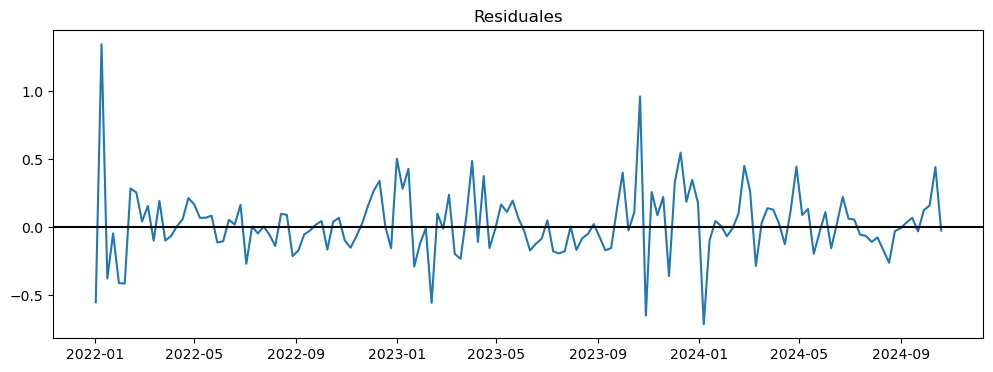

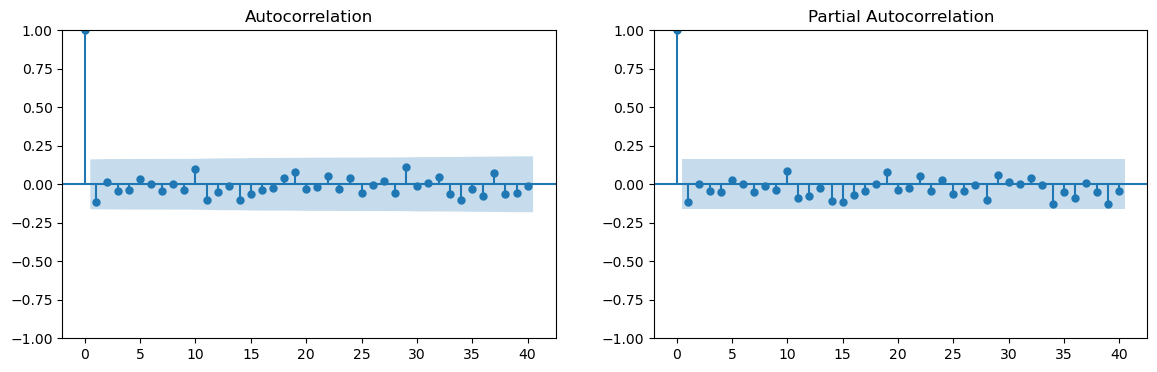

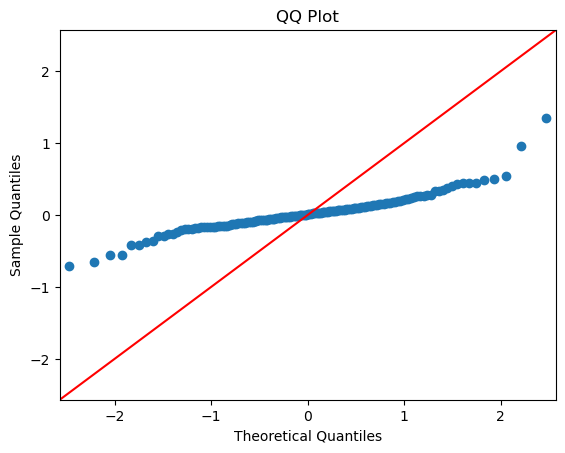

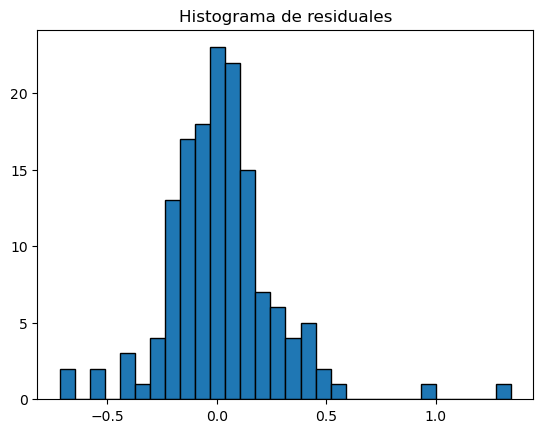

In [75]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "Y_3", y_transform=None, inverse_transform=None)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)

## Y_4

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Diario
AIC: 469.5947084604212
MAE: 3.4430187362304627
RMSE: 6.509171545604968
MAPE: 36.34975646619652
R2: 0.01525807169921889
LjungBox_p: 0.8838119674229367
JarqueBera_p: 1.0078715646308077e-59
best_order: (1, 1, 2)
  Variable      Coef  AbsImpact        Pvalue
2       SR  0.108955   0.108955  1.718580e-07
4      WSR -0.083382   0.083382  6.879583e-05
1       RH -0.020056   0.020056  2.213524e-01
3      PRS -0.015436   0.015436  4.738041e-01
5      WDR  0.011377   0.011377  4.846381e-01
0     TOUT -0.001824   0.001824  9.458601e-01
                               SARIMAX Results                                
Dep. Variable:                    Y_4   No. Observations:                 1021
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -224.797
Date:                Fri, 05 Dec 2025   AIC                            469.595
Time:                        08:38:07   BIC                            518.841
Sample:                    01-01-2022   HQ

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


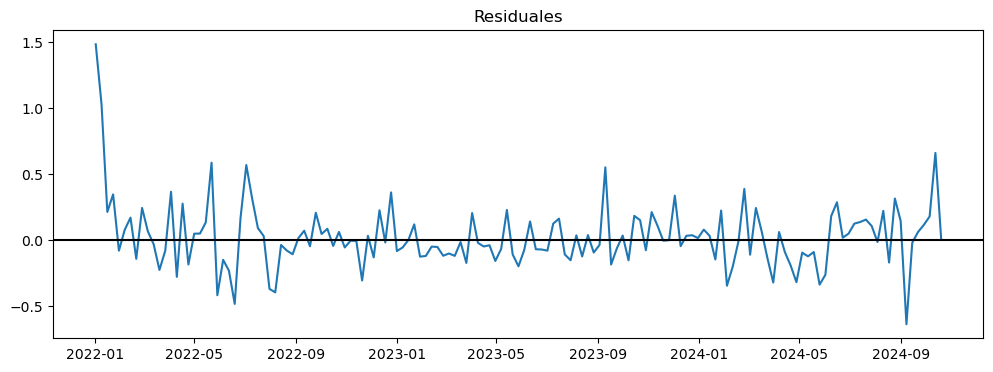

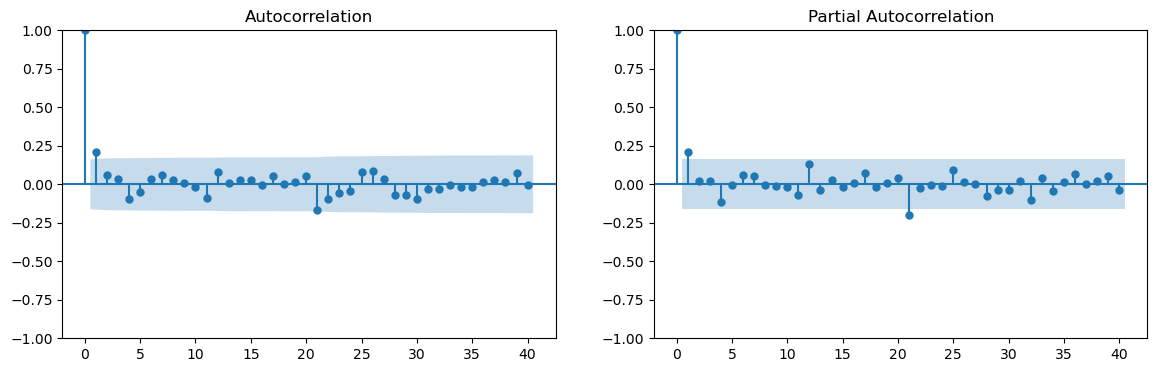

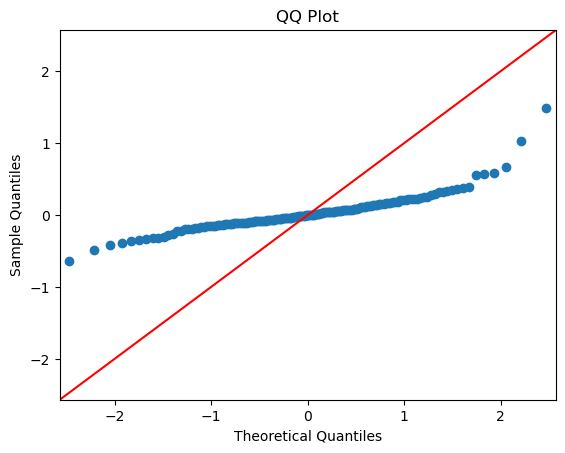

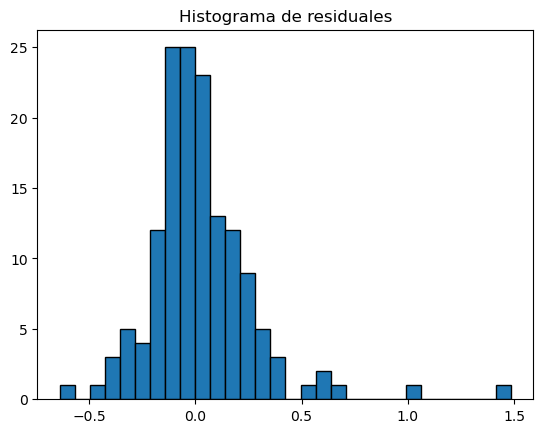

In [35]:
out = fit_best_sarimax(df_Y_diario, df_Y_semanal, "Y_4", y_transform=np.log1p, inverse_transform=np.expm1)


for best in [out["best_daily"], out["best_weekly"]]:
    print("Frecuencia seleccionada:", best["freq"])
    print("AIC:", best["AIC"])
    print("MAE:", best["MAE"])
    print("RMSE:", best["RMSE"])
    print("MAPE:", best["MAPE"])
    print("R2:", best["R2"])
    print("LjungBox_p:", best["LjungBox_p"])
    print("JarqueBera_p:", best["JarqueBera_p"])
    print("best_order:", best["best_order"])
    print(best["coef_table"])
    print(best["results"].summary())

plot_diagnostics(best)